## Assignment 2

In [25]:
import torch
torch.__version__

'0.2.0_4'

### Importing, normalizing and bootstrapping data

We are loading the data from `npz` numpy zip, splitting the training in train and validation sets and parsing those to tensor datasets for training pytorch models  

**TODO**: Bootstrap

In [26]:
import numpy as np
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

data_set = np.load('./prediction-challenge-01-data.npz')

X, y, test = data_set['data_x'], data_set['data_y'], data_set['test_x']

#### Let's try some bootstrapping

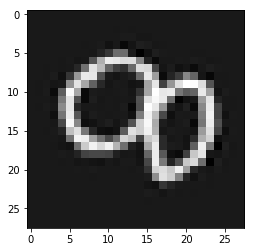

In [27]:
from scipy import ndimage
import matplotlib.pyplot as plt

plt.imshow(ndimage.rotate(X[0][0], 65, reshape=False), cmap='gray')

In [28]:
train_x, validation_x, train_y, validation_y = train_test_split(X, y, test_size=.2)

mean_image = np.mean(train_x, axis=0)
train_x -= mean_image
validation_x -= mean_image
test -= mean_image

print(X.shape)
print(y.shape)

(20000, 1, 28, 28)
(20000,)


### Rotate

Let's rotate the images a little bit in order to gain some more training data

In [29]:
new_x = train_x
new_y = train_y
for deg in range(15, 61, 15):
    new_data = []
    new_labels = y
    for i, x in enumerate(X):
        new_data.append([ndimage.rotate(x[0], 65, reshape=False)])
        
    new_x = np.vstack([new_x, new_data])
    new_y = np.append(new_y, new_labels)
train_x = new_x
train_y = new_y

In [30]:
train_dataset = data_utils.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

# to make sure everything is fine
print('Shape of training data: {}'.format(train_x.shape))
print('Labels\' shape: {}'.format(train_y.shape))

Shape of training data: (96000, 1, 28, 28)
Labels' shape: (96000,)


### Visualizing data

It's always good to know how our data looks like and what the corresponding labels are

8

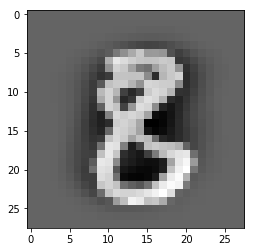

In [31]:
%matplotlib inline

plt.imshow(train_x[0][0], cmap='gray')
train_y[0]

(1, 28, 28)


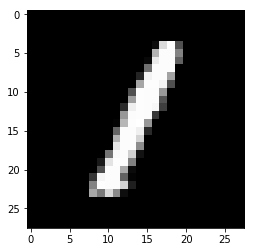

In [32]:
print((validation_x[0][0] + mean_image).shape)
plt.imshow((validation_x + mean_image)[0][0], cmap='gray')

### Mean Image

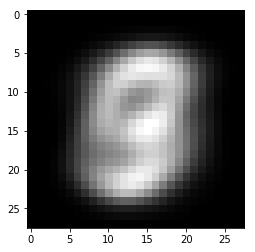

In [34]:
plt.imshow(mean_image[0], cmap='gray')

### Model

#### VGG

As done in "Mustererkennung" course in WS17, we used VGG, though not VGG11

We are using the VGG nets model. This is a pretty famous model and works great for recognizing images. Basic principle is to have some convolutional layers followed by pooling layers, the whole thing multiple times. Afterwards one usually has some number of fully connected layers, though this is originally not so in VGG. We decided to add the fully connected layers anyways, as we don't have the capcaity to run the original VGG model anyways.

Further info -> http://www.robots.ox.ac.uk/~vgg/research/very_deep/

#### Batchnorm, Dropout, Xavier

Bachnorm makes training a model quicker as it keeps mean and standart deviation consistant within the network (if the model decides it's helpful for it, how much batch normalisation is used is a learning parameter). Dropout makes sure the NN doesn't overfit, as it repeatedly temporarily disables some neurons so better generalisation is reached. Xavier is used for better weights initialisation.

#### First implementation

Score 99.2%; No FC layers, 0.005 learning rate

In [35]:
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    'VGG': [4, 8, 'M', 16, 16, 'M', 32, 32, 'M', 32, 32, 'M']
}

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv_layers, self.fc_layers = self._make_layers(cfg['VGG'])
        self.classifier = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        
        # allow for no FC
        if (len(self.fc_layers) > 0):
            x = x.view(x.size(0), x.size(1))
            x = self.fc_layers(x)

        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        conv_layers = []
        fc_layers = []
        in_channels = 1
        build_fc = False
        
        for x in cfg:
            if build_fc:
                fc = nn.Linear(in_channels, x)
                fc_layers += [fc,
                           nn.BatchNorm1d(x),
                           nn.ReLU(inplace=True)]
                nn.init.xavier_uniform(fc.weight)
            elif x == 'M':
                conv_layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif x == 'FC':
                build_fc = True
            else:
                conv = nn.Conv2d(in_channels, x, kernel_size=3, padding=1)
                conv_layers += [conv,
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                nn.init.xavier_uniform(conv.weight)
                
            if isinstance(x, int):
                in_channels = x
        conv_layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
            
        return nn.Sequential(*conv_layers), nn.Sequential(*fc_layers)

In [36]:
model = VGG()
if torch.cuda.is_available():
    model.cuda()

In [37]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [38]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}
print('num_workers={}'.format(kwargs['num_workers']))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

num_workers=16


In [39]:
from torch.autograd import Variable

def train(epoch, callback):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output, target)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [40]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss

### Prepare for plotting

In [45]:
def save_accuracy(i, output, target, save_in):
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.data.view_as(pred)).cpu().sum()
    save_in.append(100. * correct / len(output))
    
def get_save_acc_in(save_in):
    return lambda x, y, z: save_accuracy(x, y, z, save_in)

In [46]:
%%time

per_batch_acc = []
epoch_acc = []
val_losses = []
best_acc = 0

# max 200 epochs, we are going to stop training when validation score gets worse
for epoch in range(1, 200 + 1):
    train(epoch, get_save_acc_in(per_batch_acc))
    accuracy, val_loss = test()
    epoch_acc.append(accuracy)
    val_losses.append(val_loss)
    
    if best_acc < accuracy:
        best_acc = accuracy
        torch.save(model.state_dict(), './model_alternative')
    else:
        break

Train Epoch: 1 [128/96000 (0%)]	Loss: 2.355076
Train Epoch: 1 [256/96000 (0%)]	Loss: 2.361317
Train Epoch: 1 [384/96000 (0%)]	Loss: 2.300599
Train Epoch: 1 [512/96000 (1%)]	Loss: 2.334259
Train Epoch: 1 [640/96000 (1%)]	Loss: 2.353446
Train Epoch: 1 [768/96000 (1%)]	Loss: 2.270988
Train Epoch: 1 [896/96000 (1%)]	Loss: 2.308035
Train Epoch: 1 [1024/96000 (1%)]	Loss: 2.296792
Train Epoch: 1 [1152/96000 (1%)]	Loss: 2.269653
Train Epoch: 1 [1280/96000 (1%)]	Loss: 2.334387
Train Epoch: 1 [1408/96000 (1%)]	Loss: 2.338701
Train Epoch: 1 [1536/96000 (2%)]	Loss: 2.289364
Train Epoch: 1 [1664/96000 (2%)]	Loss: 2.314763
Train Epoch: 1 [1792/96000 (2%)]	Loss: 2.289215
Train Epoch: 1 [1920/96000 (2%)]	Loss: 2.292627
Train Epoch: 1 [2048/96000 (2%)]	Loss: 2.328036
Train Epoch: 1 [2176/96000 (2%)]	Loss: 2.298909
Train Epoch: 1 [2304/96000 (2%)]	Loss: 2.294667
Train Epoch: 1 [2432/96000 (3%)]	Loss: 2.248468
Train Epoch: 1 [2560/96000 (3%)]	Loss: 2.291205
Train Epoch: 1 [2688/96000 (3%)]	Loss: 2.295735

Train Epoch: 1 [21504/96000 (22%)]	Loss: 2.005632
Train Epoch: 1 [21632/96000 (23%)]	Loss: 1.940266
Train Epoch: 1 [21760/96000 (23%)]	Loss: 1.973257
Train Epoch: 1 [21888/96000 (23%)]	Loss: 2.023481
Train Epoch: 1 [22016/96000 (23%)]	Loss: 1.969134
Train Epoch: 1 [22144/96000 (23%)]	Loss: 1.983997
Train Epoch: 1 [22272/96000 (23%)]	Loss: 2.043346
Train Epoch: 1 [22400/96000 (23%)]	Loss: 2.022909
Train Epoch: 1 [22528/96000 (23%)]	Loss: 2.017373
Train Epoch: 1 [22656/96000 (24%)]	Loss: 1.893958
Train Epoch: 1 [22784/96000 (24%)]	Loss: 2.005651
Train Epoch: 1 [22912/96000 (24%)]	Loss: 1.938908
Train Epoch: 1 [23040/96000 (24%)]	Loss: 2.008957
Train Epoch: 1 [23168/96000 (24%)]	Loss: 1.933089
Train Epoch: 1 [23296/96000 (24%)]	Loss: 1.946823
Train Epoch: 1 [23424/96000 (24%)]	Loss: 1.951463
Train Epoch: 1 [23552/96000 (25%)]	Loss: 1.963068
Train Epoch: 1 [23680/96000 (25%)]	Loss: 1.930540
Train Epoch: 1 [23808/96000 (25%)]	Loss: 1.927470
Train Epoch: 1 [23936/96000 (25%)]	Loss: 1.859483


Train Epoch: 1 [42496/96000 (44%)]	Loss: 1.606638
Train Epoch: 1 [42624/96000 (44%)]	Loss: 1.621782
Train Epoch: 1 [42752/96000 (45%)]	Loss: 1.695722
Train Epoch: 1 [42880/96000 (45%)]	Loss: 1.659313
Train Epoch: 1 [43008/96000 (45%)]	Loss: 1.639947
Train Epoch: 1 [43136/96000 (45%)]	Loss: 1.602985
Train Epoch: 1 [43264/96000 (45%)]	Loss: 1.631588
Train Epoch: 1 [43392/96000 (45%)]	Loss: 1.554946
Train Epoch: 1 [43520/96000 (45%)]	Loss: 1.617584
Train Epoch: 1 [43648/96000 (45%)]	Loss: 1.621081
Train Epoch: 1 [43776/96000 (46%)]	Loss: 1.531768
Train Epoch: 1 [43904/96000 (46%)]	Loss: 1.605048
Train Epoch: 1 [44032/96000 (46%)]	Loss: 1.539158
Train Epoch: 1 [44160/96000 (46%)]	Loss: 1.541244
Train Epoch: 1 [44288/96000 (46%)]	Loss: 1.589736
Train Epoch: 1 [44416/96000 (46%)]	Loss: 1.596186
Train Epoch: 1 [44544/96000 (46%)]	Loss: 1.543923
Train Epoch: 1 [44672/96000 (47%)]	Loss: 1.666576
Train Epoch: 1 [44800/96000 (47%)]	Loss: 1.588083
Train Epoch: 1 [44928/96000 (47%)]	Loss: 1.570197


Train Epoch: 1 [63488/96000 (66%)]	Loss: 1.374089
Train Epoch: 1 [63616/96000 (66%)]	Loss: 1.291920
Train Epoch: 1 [63744/96000 (66%)]	Loss: 1.283328
Train Epoch: 1 [63872/96000 (67%)]	Loss: 1.263592
Train Epoch: 1 [64000/96000 (67%)]	Loss: 1.183132
Train Epoch: 1 [64128/96000 (67%)]	Loss: 1.260617
Train Epoch: 1 [64256/96000 (67%)]	Loss: 1.264039
Train Epoch: 1 [64384/96000 (67%)]	Loss: 1.323305
Train Epoch: 1 [64512/96000 (67%)]	Loss: 1.268904
Train Epoch: 1 [64640/96000 (67%)]	Loss: 1.323329
Train Epoch: 1 [64768/96000 (67%)]	Loss: 1.269718
Train Epoch: 1 [64896/96000 (68%)]	Loss: 1.277321
Train Epoch: 1 [65024/96000 (68%)]	Loss: 1.206363
Train Epoch: 1 [65152/96000 (68%)]	Loss: 1.236081
Train Epoch: 1 [65280/96000 (68%)]	Loss: 1.295854
Train Epoch: 1 [65408/96000 (68%)]	Loss: 1.306075
Train Epoch: 1 [65536/96000 (68%)]	Loss: 1.245498
Train Epoch: 1 [65664/96000 (68%)]	Loss: 1.250027
Train Epoch: 1 [65792/96000 (69%)]	Loss: 1.263252
Train Epoch: 1 [65920/96000 (69%)]	Loss: 1.359078


Train Epoch: 1 [84480/96000 (88%)]	Loss: 1.035788
Train Epoch: 1 [84608/96000 (88%)]	Loss: 0.964429
Train Epoch: 1 [84736/96000 (88%)]	Loss: 0.998275
Train Epoch: 1 [84864/96000 (88%)]	Loss: 1.022352
Train Epoch: 1 [84992/96000 (89%)]	Loss: 1.040299
Train Epoch: 1 [85120/96000 (89%)]	Loss: 1.098270
Train Epoch: 1 [85248/96000 (89%)]	Loss: 1.061669
Train Epoch: 1 [85376/96000 (89%)]	Loss: 1.035464
Train Epoch: 1 [85504/96000 (89%)]	Loss: 1.057328
Train Epoch: 1 [85632/96000 (89%)]	Loss: 1.050967
Train Epoch: 1 [85760/96000 (89%)]	Loss: 1.020264
Train Epoch: 1 [85888/96000 (89%)]	Loss: 1.034864
Train Epoch: 1 [86016/96000 (90%)]	Loss: 0.972761
Train Epoch: 1 [86144/96000 (90%)]	Loss: 1.071370
Train Epoch: 1 [86272/96000 (90%)]	Loss: 1.085977
Train Epoch: 1 [86400/96000 (90%)]	Loss: 1.079902
Train Epoch: 1 [86528/96000 (90%)]	Loss: 1.064799
Train Epoch: 1 [86656/96000 (90%)]	Loss: 1.148712
Train Epoch: 1 [86784/96000 (90%)]	Loss: 1.056532
Train Epoch: 1 [86912/96000 (91%)]	Loss: 1.015717


Train Epoch: 2 [9728/96000 (10%)]	Loss: 0.838666
Train Epoch: 2 [9856/96000 (10%)]	Loss: 0.849763
Train Epoch: 2 [9984/96000 (10%)]	Loss: 0.877276
Train Epoch: 2 [10112/96000 (11%)]	Loss: 0.759296
Train Epoch: 2 [10240/96000 (11%)]	Loss: 0.818718
Train Epoch: 2 [10368/96000 (11%)]	Loss: 0.871778
Train Epoch: 2 [10496/96000 (11%)]	Loss: 0.883016
Train Epoch: 2 [10624/96000 (11%)]	Loss: 0.885978
Train Epoch: 2 [10752/96000 (11%)]	Loss: 0.845568
Train Epoch: 2 [10880/96000 (11%)]	Loss: 0.703753
Train Epoch: 2 [11008/96000 (11%)]	Loss: 0.922594
Train Epoch: 2 [11136/96000 (12%)]	Loss: 0.901085
Train Epoch: 2 [11264/96000 (12%)]	Loss: 0.802466
Train Epoch: 2 [11392/96000 (12%)]	Loss: 0.840623
Train Epoch: 2 [11520/96000 (12%)]	Loss: 0.838649
Train Epoch: 2 [11648/96000 (12%)]	Loss: 0.803186
Train Epoch: 2 [11776/96000 (12%)]	Loss: 0.802573
Train Epoch: 2 [11904/96000 (12%)]	Loss: 0.882769
Train Epoch: 2 [12032/96000 (13%)]	Loss: 0.947119
Train Epoch: 2 [12160/96000 (13%)]	Loss: 0.950503
Tra

Train Epoch: 2 [30720/96000 (32%)]	Loss: 0.743705
Train Epoch: 2 [30848/96000 (32%)]	Loss: 0.749515
Train Epoch: 2 [30976/96000 (32%)]	Loss: 0.703425
Train Epoch: 2 [31104/96000 (32%)]	Loss: 0.784277
Train Epoch: 2 [31232/96000 (33%)]	Loss: 0.668362
Train Epoch: 2 [31360/96000 (33%)]	Loss: 0.682004
Train Epoch: 2 [31488/96000 (33%)]	Loss: 0.661636
Train Epoch: 2 [31616/96000 (33%)]	Loss: 0.714825
Train Epoch: 2 [31744/96000 (33%)]	Loss: 0.742900
Train Epoch: 2 [31872/96000 (33%)]	Loss: 0.622984
Train Epoch: 2 [32000/96000 (33%)]	Loss: 0.665639
Train Epoch: 2 [32128/96000 (33%)]	Loss: 0.687983
Train Epoch: 2 [32256/96000 (34%)]	Loss: 0.711308
Train Epoch: 2 [32384/96000 (34%)]	Loss: 0.732622
Train Epoch: 2 [32512/96000 (34%)]	Loss: 0.679328
Train Epoch: 2 [32640/96000 (34%)]	Loss: 0.631784
Train Epoch: 2 [32768/96000 (34%)]	Loss: 0.706931
Train Epoch: 2 [32896/96000 (34%)]	Loss: 0.682658
Train Epoch: 2 [33024/96000 (34%)]	Loss: 0.691807
Train Epoch: 2 [33152/96000 (35%)]	Loss: 0.717049


Train Epoch: 2 [51712/96000 (54%)]	Loss: 0.566060
Train Epoch: 2 [51840/96000 (54%)]	Loss: 0.567972
Train Epoch: 2 [51968/96000 (54%)]	Loss: 0.526349
Train Epoch: 2 [52096/96000 (54%)]	Loss: 0.630301
Train Epoch: 2 [52224/96000 (54%)]	Loss: 0.619244
Train Epoch: 2 [52352/96000 (55%)]	Loss: 0.535536
Train Epoch: 2 [52480/96000 (55%)]	Loss: 0.614828
Train Epoch: 2 [52608/96000 (55%)]	Loss: 0.672118
Train Epoch: 2 [52736/96000 (55%)]	Loss: 0.697300
Train Epoch: 2 [52864/96000 (55%)]	Loss: 0.639152
Train Epoch: 2 [52992/96000 (55%)]	Loss: 0.593388
Train Epoch: 2 [53120/96000 (55%)]	Loss: 0.639082
Train Epoch: 2 [53248/96000 (55%)]	Loss: 0.572503
Train Epoch: 2 [53376/96000 (56%)]	Loss: 0.587845
Train Epoch: 2 [53504/96000 (56%)]	Loss: 0.514761
Train Epoch: 2 [53632/96000 (56%)]	Loss: 0.619862
Train Epoch: 2 [53760/96000 (56%)]	Loss: 0.579468
Train Epoch: 2 [53888/96000 (56%)]	Loss: 0.592420
Train Epoch: 2 [54016/96000 (56%)]	Loss: 0.645624
Train Epoch: 2 [54144/96000 (56%)]	Loss: 0.586911


Train Epoch: 2 [72704/96000 (76%)]	Loss: 0.545430
Train Epoch: 2 [72832/96000 (76%)]	Loss: 0.512804
Train Epoch: 2 [72960/96000 (76%)]	Loss: 0.611116
Train Epoch: 2 [73088/96000 (76%)]	Loss: 0.435069
Train Epoch: 2 [73216/96000 (76%)]	Loss: 0.482813
Train Epoch: 2 [73344/96000 (76%)]	Loss: 0.570425
Train Epoch: 2 [73472/96000 (77%)]	Loss: 0.479478
Train Epoch: 2 [73600/96000 (77%)]	Loss: 0.564945
Train Epoch: 2 [73728/96000 (77%)]	Loss: 0.569790
Train Epoch: 2 [73856/96000 (77%)]	Loss: 0.523556
Train Epoch: 2 [73984/96000 (77%)]	Loss: 0.532589
Train Epoch: 2 [74112/96000 (77%)]	Loss: 0.519171
Train Epoch: 2 [74240/96000 (77%)]	Loss: 0.483639
Train Epoch: 2 [74368/96000 (77%)]	Loss: 0.567264
Train Epoch: 2 [74496/96000 (78%)]	Loss: 0.536802
Train Epoch: 2 [74624/96000 (78%)]	Loss: 0.462439
Train Epoch: 2 [74752/96000 (78%)]	Loss: 0.473069
Train Epoch: 2 [74880/96000 (78%)]	Loss: 0.502311
Train Epoch: 2 [75008/96000 (78%)]	Loss: 0.572667
Train Epoch: 2 [75136/96000 (78%)]	Loss: 0.473673


Train Epoch: 2 [93696/96000 (98%)]	Loss: 0.462953
Train Epoch: 2 [93824/96000 (98%)]	Loss: 0.520781
Train Epoch: 2 [93952/96000 (98%)]	Loss: 0.425437
Train Epoch: 2 [94080/96000 (98%)]	Loss: 0.368425
Train Epoch: 2 [94208/96000 (98%)]	Loss: 0.470053
Train Epoch: 2 [94336/96000 (98%)]	Loss: 0.434948
Train Epoch: 2 [94464/96000 (98%)]	Loss: 0.412273
Train Epoch: 2 [94592/96000 (99%)]	Loss: 0.608426
Train Epoch: 2 [94720/96000 (99%)]	Loss: 0.431593
Train Epoch: 2 [94848/96000 (99%)]	Loss: 0.400985
Train Epoch: 2 [94976/96000 (99%)]	Loss: 0.385033
Train Epoch: 2 [95104/96000 (99%)]	Loss: 0.451508
Train Epoch: 2 [95232/96000 (99%)]	Loss: 0.549402
Train Epoch: 2 [95360/96000 (99%)]	Loss: 0.500160
Train Epoch: 2 [95488/96000 (99%)]	Loss: 0.505372
Train Epoch: 2 [95616/96000 (100%)]	Loss: 0.440564
Train Epoch: 2 [95744/96000 (100%)]	Loss: 0.445783
Train Epoch: 2 [95872/96000 (100%)]	Loss: 0.481241
Train Epoch: 2 [96000/96000 (100%)]	Loss: 0.480588

Test set: Average loss: 0.9579, Accuracy: 310

Train Epoch: 3 [18944/96000 (20%)]	Loss: 0.481938
Train Epoch: 3 [19072/96000 (20%)]	Loss: 0.372307
Train Epoch: 3 [19200/96000 (20%)]	Loss: 0.492665
Train Epoch: 3 [19328/96000 (20%)]	Loss: 0.362819
Train Epoch: 3 [19456/96000 (20%)]	Loss: 0.430543
Train Epoch: 3 [19584/96000 (20%)]	Loss: 0.388961
Train Epoch: 3 [19712/96000 (21%)]	Loss: 0.358162
Train Epoch: 3 [19840/96000 (21%)]	Loss: 0.341237
Train Epoch: 3 [19968/96000 (21%)]	Loss: 0.486702
Train Epoch: 3 [20096/96000 (21%)]	Loss: 0.504492
Train Epoch: 3 [20224/96000 (21%)]	Loss: 0.338006
Train Epoch: 3 [20352/96000 (21%)]	Loss: 0.397267
Train Epoch: 3 [20480/96000 (21%)]	Loss: 0.433163
Train Epoch: 3 [20608/96000 (21%)]	Loss: 0.345872
Train Epoch: 3 [20736/96000 (22%)]	Loss: 0.364724
Train Epoch: 3 [20864/96000 (22%)]	Loss: 0.343187
Train Epoch: 3 [20992/96000 (22%)]	Loss: 0.427104
Train Epoch: 3 [21120/96000 (22%)]	Loss: 0.349364
Train Epoch: 3 [21248/96000 (22%)]	Loss: 0.327809
Train Epoch: 3 [21376/96000 (22%)]	Loss: 0.341501


Train Epoch: 3 [39936/96000 (42%)]	Loss: 0.397891
Train Epoch: 3 [40064/96000 (42%)]	Loss: 0.282392
Train Epoch: 3 [40192/96000 (42%)]	Loss: 0.420087
Train Epoch: 3 [40320/96000 (42%)]	Loss: 0.374003
Train Epoch: 3 [40448/96000 (42%)]	Loss: 0.351509
Train Epoch: 3 [40576/96000 (42%)]	Loss: 0.341627
Train Epoch: 3 [40704/96000 (42%)]	Loss: 0.339593
Train Epoch: 3 [40832/96000 (43%)]	Loss: 0.327752
Train Epoch: 3 [40960/96000 (43%)]	Loss: 0.279894
Train Epoch: 3 [41088/96000 (43%)]	Loss: 0.379076
Train Epoch: 3 [41216/96000 (43%)]	Loss: 0.371693
Train Epoch: 3 [41344/96000 (43%)]	Loss: 0.372070
Train Epoch: 3 [41472/96000 (43%)]	Loss: 0.331427
Train Epoch: 3 [41600/96000 (43%)]	Loss: 0.351215
Train Epoch: 3 [41728/96000 (43%)]	Loss: 0.416572
Train Epoch: 3 [41856/96000 (44%)]	Loss: 0.348913
Train Epoch: 3 [41984/96000 (44%)]	Loss: 0.342115
Train Epoch: 3 [42112/96000 (44%)]	Loss: 0.329516
Train Epoch: 3 [42240/96000 (44%)]	Loss: 0.316572
Train Epoch: 3 [42368/96000 (44%)]	Loss: 0.355752


Train Epoch: 3 [60928/96000 (63%)]	Loss: 0.314257
Train Epoch: 3 [61056/96000 (64%)]	Loss: 0.228251
Train Epoch: 3 [61184/96000 (64%)]	Loss: 0.298111
Train Epoch: 3 [61312/96000 (64%)]	Loss: 0.325323
Train Epoch: 3 [61440/96000 (64%)]	Loss: 0.342226
Train Epoch: 3 [61568/96000 (64%)]	Loss: 0.300409
Train Epoch: 3 [61696/96000 (64%)]	Loss: 0.362062
Train Epoch: 3 [61824/96000 (64%)]	Loss: 0.285826
Train Epoch: 3 [61952/96000 (65%)]	Loss: 0.266408
Train Epoch: 3 [62080/96000 (65%)]	Loss: 0.347484
Train Epoch: 3 [62208/96000 (65%)]	Loss: 0.303703
Train Epoch: 3 [62336/96000 (65%)]	Loss: 0.310155
Train Epoch: 3 [62464/96000 (65%)]	Loss: 0.381067
Train Epoch: 3 [62592/96000 (65%)]	Loss: 0.329877
Train Epoch: 3 [62720/96000 (65%)]	Loss: 0.273479
Train Epoch: 3 [62848/96000 (65%)]	Loss: 0.316449
Train Epoch: 3 [62976/96000 (66%)]	Loss: 0.329991
Train Epoch: 3 [63104/96000 (66%)]	Loss: 0.358966
Train Epoch: 3 [63232/96000 (66%)]	Loss: 0.273758
Train Epoch: 3 [63360/96000 (66%)]	Loss: 0.312805


Train Epoch: 3 [81920/96000 (85%)]	Loss: 0.262149
Train Epoch: 3 [82048/96000 (85%)]	Loss: 0.314990
Train Epoch: 3 [82176/96000 (86%)]	Loss: 0.276138
Train Epoch: 3 [82304/96000 (86%)]	Loss: 0.318404
Train Epoch: 3 [82432/96000 (86%)]	Loss: 0.270357
Train Epoch: 3 [82560/96000 (86%)]	Loss: 0.221517
Train Epoch: 3 [82688/96000 (86%)]	Loss: 0.290418
Train Epoch: 3 [82816/96000 (86%)]	Loss: 0.276390
Train Epoch: 3 [82944/96000 (86%)]	Loss: 0.286400
Train Epoch: 3 [83072/96000 (87%)]	Loss: 0.230262
Train Epoch: 3 [83200/96000 (87%)]	Loss: 0.251137
Train Epoch: 3 [83328/96000 (87%)]	Loss: 0.335012
Train Epoch: 3 [83456/96000 (87%)]	Loss: 0.298943
Train Epoch: 3 [83584/96000 (87%)]	Loss: 0.274539
Train Epoch: 3 [83712/96000 (87%)]	Loss: 0.284654
Train Epoch: 3 [83840/96000 (87%)]	Loss: 0.326846
Train Epoch: 3 [83968/96000 (87%)]	Loss: 0.367224
Train Epoch: 3 [84096/96000 (88%)]	Loss: 0.369782
Train Epoch: 3 [84224/96000 (88%)]	Loss: 0.301136
Train Epoch: 3 [84352/96000 (88%)]	Loss: 0.296818


Train Epoch: 4 [7040/96000 (7%)]	Loss: 0.239724
Train Epoch: 4 [7168/96000 (7%)]	Loss: 0.294571
Train Epoch: 4 [7296/96000 (8%)]	Loss: 0.307328
Train Epoch: 4 [7424/96000 (8%)]	Loss: 0.326346
Train Epoch: 4 [7552/96000 (8%)]	Loss: 0.243508
Train Epoch: 4 [7680/96000 (8%)]	Loss: 0.276772
Train Epoch: 4 [7808/96000 (8%)]	Loss: 0.272307
Train Epoch: 4 [7936/96000 (8%)]	Loss: 0.282819
Train Epoch: 4 [8064/96000 (8%)]	Loss: 0.282794
Train Epoch: 4 [8192/96000 (9%)]	Loss: 0.261234
Train Epoch: 4 [8320/96000 (9%)]	Loss: 0.266113
Train Epoch: 4 [8448/96000 (9%)]	Loss: 0.327361
Train Epoch: 4 [8576/96000 (9%)]	Loss: 0.240628
Train Epoch: 4 [8704/96000 (9%)]	Loss: 0.244614
Train Epoch: 4 [8832/96000 (9%)]	Loss: 0.200190
Train Epoch: 4 [8960/96000 (9%)]	Loss: 0.240368
Train Epoch: 4 [9088/96000 (9%)]	Loss: 0.304116
Train Epoch: 4 [9216/96000 (10%)]	Loss: 0.213914
Train Epoch: 4 [9344/96000 (10%)]	Loss: 0.248960
Train Epoch: 4 [9472/96000 (10%)]	Loss: 0.300177
Train Epoch: 4 [9600/96000 (10%)]	Los

Train Epoch: 4 [28160/96000 (29%)]	Loss: 0.303563
Train Epoch: 4 [28288/96000 (29%)]	Loss: 0.305653
Train Epoch: 4 [28416/96000 (30%)]	Loss: 0.203097
Train Epoch: 4 [28544/96000 (30%)]	Loss: 0.269578
Train Epoch: 4 [28672/96000 (30%)]	Loss: 0.228490
Train Epoch: 4 [28800/96000 (30%)]	Loss: 0.195565
Train Epoch: 4 [28928/96000 (30%)]	Loss: 0.239334
Train Epoch: 4 [29056/96000 (30%)]	Loss: 0.231827
Train Epoch: 4 [29184/96000 (30%)]	Loss: 0.218244
Train Epoch: 4 [29312/96000 (31%)]	Loss: 0.239371
Train Epoch: 4 [29440/96000 (31%)]	Loss: 0.246475
Train Epoch: 4 [29568/96000 (31%)]	Loss: 0.137447
Train Epoch: 4 [29696/96000 (31%)]	Loss: 0.240925
Train Epoch: 4 [29824/96000 (31%)]	Loss: 0.177700
Train Epoch: 4 [29952/96000 (31%)]	Loss: 0.313437
Train Epoch: 4 [30080/96000 (31%)]	Loss: 0.277238
Train Epoch: 4 [30208/96000 (31%)]	Loss: 0.231403
Train Epoch: 4 [30336/96000 (32%)]	Loss: 0.227708
Train Epoch: 4 [30464/96000 (32%)]	Loss: 0.225849
Train Epoch: 4 [30592/96000 (32%)]	Loss: 0.250908


Train Epoch: 4 [49152/96000 (51%)]	Loss: 0.212735
Train Epoch: 4 [49280/96000 (51%)]	Loss: 0.213174
Train Epoch: 4 [49408/96000 (51%)]	Loss: 0.248941
Train Epoch: 4 [49536/96000 (52%)]	Loss: 0.217376
Train Epoch: 4 [49664/96000 (52%)]	Loss: 0.237661
Train Epoch: 4 [49792/96000 (52%)]	Loss: 0.231896
Train Epoch: 4 [49920/96000 (52%)]	Loss: 0.195218
Train Epoch: 4 [50048/96000 (52%)]	Loss: 0.215410
Train Epoch: 4 [50176/96000 (52%)]	Loss: 0.213154
Train Epoch: 4 [50304/96000 (52%)]	Loss: 0.169969
Train Epoch: 4 [50432/96000 (53%)]	Loss: 0.170043
Train Epoch: 4 [50560/96000 (53%)]	Loss: 0.219029
Train Epoch: 4 [50688/96000 (53%)]	Loss: 0.205493
Train Epoch: 4 [50816/96000 (53%)]	Loss: 0.259951
Train Epoch: 4 [50944/96000 (53%)]	Loss: 0.188468
Train Epoch: 4 [51072/96000 (53%)]	Loss: 0.417292
Train Epoch: 4 [51200/96000 (53%)]	Loss: 0.277112
Train Epoch: 4 [51328/96000 (53%)]	Loss: 0.271123
Train Epoch: 4 [51456/96000 (54%)]	Loss: 0.206133
Train Epoch: 4 [51584/96000 (54%)]	Loss: 0.155682


Train Epoch: 4 [70144/96000 (73%)]	Loss: 0.226376
Train Epoch: 4 [70272/96000 (73%)]	Loss: 0.222757
Train Epoch: 4 [70400/96000 (73%)]	Loss: 0.207858
Train Epoch: 4 [70528/96000 (73%)]	Loss: 0.244880
Train Epoch: 4 [70656/96000 (74%)]	Loss: 0.217682
Train Epoch: 4 [70784/96000 (74%)]	Loss: 0.209816
Train Epoch: 4 [70912/96000 (74%)]	Loss: 0.199635
Train Epoch: 4 [71040/96000 (74%)]	Loss: 0.182717
Train Epoch: 4 [71168/96000 (74%)]	Loss: 0.195471
Train Epoch: 4 [71296/96000 (74%)]	Loss: 0.156925
Train Epoch: 4 [71424/96000 (74%)]	Loss: 0.228339
Train Epoch: 4 [71552/96000 (75%)]	Loss: 0.210631
Train Epoch: 4 [71680/96000 (75%)]	Loss: 0.202899
Train Epoch: 4 [71808/96000 (75%)]	Loss: 0.157036
Train Epoch: 4 [71936/96000 (75%)]	Loss: 0.171058
Train Epoch: 4 [72064/96000 (75%)]	Loss: 0.212081
Train Epoch: 4 [72192/96000 (75%)]	Loss: 0.196025
Train Epoch: 4 [72320/96000 (75%)]	Loss: 0.198151
Train Epoch: 4 [72448/96000 (75%)]	Loss: 0.141787
Train Epoch: 4 [72576/96000 (76%)]	Loss: 0.210229


Train Epoch: 4 [91136/96000 (95%)]	Loss: 0.149333
Train Epoch: 4 [91264/96000 (95%)]	Loss: 0.218410
Train Epoch: 4 [91392/96000 (95%)]	Loss: 0.190708
Train Epoch: 4 [91520/96000 (95%)]	Loss: 0.247358
Train Epoch: 4 [91648/96000 (95%)]	Loss: 0.196237
Train Epoch: 4 [91776/96000 (96%)]	Loss: 0.164534
Train Epoch: 4 [91904/96000 (96%)]	Loss: 0.180242
Train Epoch: 4 [92032/96000 (96%)]	Loss: 0.223321
Train Epoch: 4 [92160/96000 (96%)]	Loss: 0.245268
Train Epoch: 4 [92288/96000 (96%)]	Loss: 0.232545
Train Epoch: 4 [92416/96000 (96%)]	Loss: 0.168226
Train Epoch: 4 [92544/96000 (96%)]	Loss: 0.152075
Train Epoch: 4 [92672/96000 (97%)]	Loss: 0.170133
Train Epoch: 4 [92800/96000 (97%)]	Loss: 0.205069
Train Epoch: 4 [92928/96000 (97%)]	Loss: 0.190924
Train Epoch: 4 [93056/96000 (97%)]	Loss: 0.197600
Train Epoch: 4 [93184/96000 (97%)]	Loss: 0.174379
Train Epoch: 4 [93312/96000 (97%)]	Loss: 0.195835
Train Epoch: 4 [93440/96000 (97%)]	Loss: 0.218563
Train Epoch: 4 [93568/96000 (97%)]	Loss: 0.161684


Train Epoch: 5 [16384/96000 (17%)]	Loss: 0.165371
Train Epoch: 5 [16512/96000 (17%)]	Loss: 0.221502
Train Epoch: 5 [16640/96000 (17%)]	Loss: 0.136328
Train Epoch: 5 [16768/96000 (17%)]	Loss: 0.171184
Train Epoch: 5 [16896/96000 (18%)]	Loss: 0.158000
Train Epoch: 5 [17024/96000 (18%)]	Loss: 0.214598
Train Epoch: 5 [17152/96000 (18%)]	Loss: 0.208595
Train Epoch: 5 [17280/96000 (18%)]	Loss: 0.176767
Train Epoch: 5 [17408/96000 (18%)]	Loss: 0.172211
Train Epoch: 5 [17536/96000 (18%)]	Loss: 0.147574
Train Epoch: 5 [17664/96000 (18%)]	Loss: 0.182286
Train Epoch: 5 [17792/96000 (19%)]	Loss: 0.097540
Train Epoch: 5 [17920/96000 (19%)]	Loss: 0.182795
Train Epoch: 5 [18048/96000 (19%)]	Loss: 0.187840
Train Epoch: 5 [18176/96000 (19%)]	Loss: 0.149245
Train Epoch: 5 [18304/96000 (19%)]	Loss: 0.189031
Train Epoch: 5 [18432/96000 (19%)]	Loss: 0.238569
Train Epoch: 5 [18560/96000 (19%)]	Loss: 0.197368
Train Epoch: 5 [18688/96000 (19%)]	Loss: 0.161632
Train Epoch: 5 [18816/96000 (20%)]	Loss: 0.145644


Train Epoch: 5 [37376/96000 (39%)]	Loss: 0.121789
Train Epoch: 5 [37504/96000 (39%)]	Loss: 0.204829
Train Epoch: 5 [37632/96000 (39%)]	Loss: 0.132312
Train Epoch: 5 [37760/96000 (39%)]	Loss: 0.135060
Train Epoch: 5 [37888/96000 (39%)]	Loss: 0.173513
Train Epoch: 5 [38016/96000 (40%)]	Loss: 0.196632
Train Epoch: 5 [38144/96000 (40%)]	Loss: 0.187149
Train Epoch: 5 [38272/96000 (40%)]	Loss: 0.179903
Train Epoch: 5 [38400/96000 (40%)]	Loss: 0.163525
Train Epoch: 5 [38528/96000 (40%)]	Loss: 0.142093
Train Epoch: 5 [38656/96000 (40%)]	Loss: 0.162636
Train Epoch: 5 [38784/96000 (40%)]	Loss: 0.199936
Train Epoch: 5 [38912/96000 (41%)]	Loss: 0.176244
Train Epoch: 5 [39040/96000 (41%)]	Loss: 0.192713
Train Epoch: 5 [39168/96000 (41%)]	Loss: 0.234550
Train Epoch: 5 [39296/96000 (41%)]	Loss: 0.134005
Train Epoch: 5 [39424/96000 (41%)]	Loss: 0.133064
Train Epoch: 5 [39552/96000 (41%)]	Loss: 0.159015
Train Epoch: 5 [39680/96000 (41%)]	Loss: 0.182633
Train Epoch: 5 [39808/96000 (41%)]	Loss: 0.116472


Train Epoch: 5 [58368/96000 (61%)]	Loss: 0.154424
Train Epoch: 5 [58496/96000 (61%)]	Loss: 0.159429
Train Epoch: 5 [58624/96000 (61%)]	Loss: 0.163707
Train Epoch: 5 [58752/96000 (61%)]	Loss: 0.157597
Train Epoch: 5 [58880/96000 (61%)]	Loss: 0.124406
Train Epoch: 5 [59008/96000 (61%)]	Loss: 0.106745
Train Epoch: 5 [59136/96000 (62%)]	Loss: 0.149782
Train Epoch: 5 [59264/96000 (62%)]	Loss: 0.171791
Train Epoch: 5 [59392/96000 (62%)]	Loss: 0.159800
Train Epoch: 5 [59520/96000 (62%)]	Loss: 0.180605
Train Epoch: 5 [59648/96000 (62%)]	Loss: 0.143836
Train Epoch: 5 [59776/96000 (62%)]	Loss: 0.146303
Train Epoch: 5 [59904/96000 (62%)]	Loss: 0.155282
Train Epoch: 5 [60032/96000 (63%)]	Loss: 0.171106
Train Epoch: 5 [60160/96000 (63%)]	Loss: 0.109841
Train Epoch: 5 [60288/96000 (63%)]	Loss: 0.133362
Train Epoch: 5 [60416/96000 (63%)]	Loss: 0.127615
Train Epoch: 5 [60544/96000 (63%)]	Loss: 0.191959
Train Epoch: 5 [60672/96000 (63%)]	Loss: 0.158587
Train Epoch: 5 [60800/96000 (63%)]	Loss: 0.164827


Train Epoch: 5 [79360/96000 (83%)]	Loss: 0.114030
Train Epoch: 5 [79488/96000 (83%)]	Loss: 0.160813
Train Epoch: 5 [79616/96000 (83%)]	Loss: 0.135146
Train Epoch: 5 [79744/96000 (83%)]	Loss: 0.135013
Train Epoch: 5 [79872/96000 (83%)]	Loss: 0.136400
Train Epoch: 5 [80000/96000 (83%)]	Loss: 0.206276
Train Epoch: 5 [80128/96000 (83%)]	Loss: 0.076169
Train Epoch: 5 [80256/96000 (84%)]	Loss: 0.101097
Train Epoch: 5 [80384/96000 (84%)]	Loss: 0.173330
Train Epoch: 5 [80512/96000 (84%)]	Loss: 0.159715
Train Epoch: 5 [80640/96000 (84%)]	Loss: 0.120872
Train Epoch: 5 [80768/96000 (84%)]	Loss: 0.139038
Train Epoch: 5 [80896/96000 (84%)]	Loss: 0.102413
Train Epoch: 5 [81024/96000 (84%)]	Loss: 0.159771
Train Epoch: 5 [81152/96000 (85%)]	Loss: 0.099997
Train Epoch: 5 [81280/96000 (85%)]	Loss: 0.130790
Train Epoch: 5 [81408/96000 (85%)]	Loss: 0.181309
Train Epoch: 5 [81536/96000 (85%)]	Loss: 0.166499
Train Epoch: 5 [81664/96000 (85%)]	Loss: 0.118801
Train Epoch: 5 [81792/96000 (85%)]	Loss: 0.175422


Train Epoch: 6 [4352/96000 (5%)]	Loss: 0.212858
Train Epoch: 6 [4480/96000 (5%)]	Loss: 0.150903
Train Epoch: 6 [4608/96000 (5%)]	Loss: 0.138380
Train Epoch: 6 [4736/96000 (5%)]	Loss: 0.177131
Train Epoch: 6 [4864/96000 (5%)]	Loss: 0.115306
Train Epoch: 6 [4992/96000 (5%)]	Loss: 0.158978
Train Epoch: 6 [5120/96000 (5%)]	Loss: 0.103205
Train Epoch: 6 [5248/96000 (5%)]	Loss: 0.104626
Train Epoch: 6 [5376/96000 (6%)]	Loss: 0.142738
Train Epoch: 6 [5504/96000 (6%)]	Loss: 0.136626
Train Epoch: 6 [5632/96000 (6%)]	Loss: 0.110952
Train Epoch: 6 [5760/96000 (6%)]	Loss: 0.126396
Train Epoch: 6 [5888/96000 (6%)]	Loss: 0.180083
Train Epoch: 6 [6016/96000 (6%)]	Loss: 0.126321
Train Epoch: 6 [6144/96000 (6%)]	Loss: 0.099512
Train Epoch: 6 [6272/96000 (7%)]	Loss: 0.140341
Train Epoch: 6 [6400/96000 (7%)]	Loss: 0.150878
Train Epoch: 6 [6528/96000 (7%)]	Loss: 0.120696
Train Epoch: 6 [6656/96000 (7%)]	Loss: 0.129895
Train Epoch: 6 [6784/96000 (7%)]	Loss: 0.102038
Train Epoch: 6 [6912/96000 (7%)]	Loss: 0

Train Epoch: 6 [25600/96000 (27%)]	Loss: 0.123235
Train Epoch: 6 [25728/96000 (27%)]	Loss: 0.109939
Train Epoch: 6 [25856/96000 (27%)]	Loss: 0.134780
Train Epoch: 6 [25984/96000 (27%)]	Loss: 0.097069
Train Epoch: 6 [26112/96000 (27%)]	Loss: 0.124303
Train Epoch: 6 [26240/96000 (27%)]	Loss: 0.117546
Train Epoch: 6 [26368/96000 (27%)]	Loss: 0.147865
Train Epoch: 6 [26496/96000 (28%)]	Loss: 0.148717
Train Epoch: 6 [26624/96000 (28%)]	Loss: 0.123399
Train Epoch: 6 [26752/96000 (28%)]	Loss: 0.115076
Train Epoch: 6 [26880/96000 (28%)]	Loss: 0.159602
Train Epoch: 6 [27008/96000 (28%)]	Loss: 0.126968
Train Epoch: 6 [27136/96000 (28%)]	Loss: 0.098194
Train Epoch: 6 [27264/96000 (28%)]	Loss: 0.149564
Train Epoch: 6 [27392/96000 (29%)]	Loss: 0.221794
Train Epoch: 6 [27520/96000 (29%)]	Loss: 0.109187
Train Epoch: 6 [27648/96000 (29%)]	Loss: 0.097833
Train Epoch: 6 [27776/96000 (29%)]	Loss: 0.064261
Train Epoch: 6 [27904/96000 (29%)]	Loss: 0.096099
Train Epoch: 6 [28032/96000 (29%)]	Loss: 0.144513


Train Epoch: 6 [46592/96000 (49%)]	Loss: 0.159267
Train Epoch: 6 [46720/96000 (49%)]	Loss: 0.102732
Train Epoch: 6 [46848/96000 (49%)]	Loss: 0.121801
Train Epoch: 6 [46976/96000 (49%)]	Loss: 0.111395
Train Epoch: 6 [47104/96000 (49%)]	Loss: 0.181184
Train Epoch: 6 [47232/96000 (49%)]	Loss: 0.098485
Train Epoch: 6 [47360/96000 (49%)]	Loss: 0.123389
Train Epoch: 6 [47488/96000 (49%)]	Loss: 0.166456
Train Epoch: 6 [47616/96000 (50%)]	Loss: 0.091025
Train Epoch: 6 [47744/96000 (50%)]	Loss: 0.110301
Train Epoch: 6 [47872/96000 (50%)]	Loss: 0.083878
Train Epoch: 6 [48000/96000 (50%)]	Loss: 0.077399
Train Epoch: 6 [48128/96000 (50%)]	Loss: 0.186067
Train Epoch: 6 [48256/96000 (50%)]	Loss: 0.093707
Train Epoch: 6 [48384/96000 (50%)]	Loss: 0.152431
Train Epoch: 6 [48512/96000 (51%)]	Loss: 0.153665
Train Epoch: 6 [48640/96000 (51%)]	Loss: 0.118774
Train Epoch: 6 [48768/96000 (51%)]	Loss: 0.163699
Train Epoch: 6 [48896/96000 (51%)]	Loss: 0.118971
Train Epoch: 6 [49024/96000 (51%)]	Loss: 0.114520


Train Epoch: 6 [67584/96000 (70%)]	Loss: 0.101138
Train Epoch: 6 [67712/96000 (71%)]	Loss: 0.206112
Train Epoch: 6 [67840/96000 (71%)]	Loss: 0.123575
Train Epoch: 6 [67968/96000 (71%)]	Loss: 0.096702
Train Epoch: 6 [68096/96000 (71%)]	Loss: 0.096542
Train Epoch: 6 [68224/96000 (71%)]	Loss: 0.125541
Train Epoch: 6 [68352/96000 (71%)]	Loss: 0.076253
Train Epoch: 6 [68480/96000 (71%)]	Loss: 0.140378
Train Epoch: 6 [68608/96000 (71%)]	Loss: 0.110263
Train Epoch: 6 [68736/96000 (72%)]	Loss: 0.170693
Train Epoch: 6 [68864/96000 (72%)]	Loss: 0.099351
Train Epoch: 6 [68992/96000 (72%)]	Loss: 0.082367
Train Epoch: 6 [69120/96000 (72%)]	Loss: 0.100121
Train Epoch: 6 [69248/96000 (72%)]	Loss: 0.072284
Train Epoch: 6 [69376/96000 (72%)]	Loss: 0.062420
Train Epoch: 6 [69504/96000 (72%)]	Loss: 0.048373
Train Epoch: 6 [69632/96000 (73%)]	Loss: 0.100118
Train Epoch: 6 [69760/96000 (73%)]	Loss: 0.093925
Train Epoch: 6 [69888/96000 (73%)]	Loss: 0.057401
Train Epoch: 6 [70016/96000 (73%)]	Loss: 0.142871


Train Epoch: 6 [88576/96000 (92%)]	Loss: 0.084920
Train Epoch: 6 [88704/96000 (92%)]	Loss: 0.095760
Train Epoch: 6 [88832/96000 (93%)]	Loss: 0.128594
Train Epoch: 6 [88960/96000 (93%)]	Loss: 0.092110
Train Epoch: 6 [89088/96000 (93%)]	Loss: 0.088932
Train Epoch: 6 [89216/96000 (93%)]	Loss: 0.144071
Train Epoch: 6 [89344/96000 (93%)]	Loss: 0.080933
Train Epoch: 6 [89472/96000 (93%)]	Loss: 0.107653
Train Epoch: 6 [89600/96000 (93%)]	Loss: 0.132148
Train Epoch: 6 [89728/96000 (93%)]	Loss: 0.106871
Train Epoch: 6 [89856/96000 (94%)]	Loss: 0.122112
Train Epoch: 6 [89984/96000 (94%)]	Loss: 0.136913
Train Epoch: 6 [90112/96000 (94%)]	Loss: 0.126023
Train Epoch: 6 [90240/96000 (94%)]	Loss: 0.084864
Train Epoch: 6 [90368/96000 (94%)]	Loss: 0.098642
Train Epoch: 6 [90496/96000 (94%)]	Loss: 0.111355
Train Epoch: 6 [90624/96000 (94%)]	Loss: 0.119399
Train Epoch: 6 [90752/96000 (95%)]	Loss: 0.081664
Train Epoch: 6 [90880/96000 (95%)]	Loss: 0.129809
Train Epoch: 6 [91008/96000 (95%)]	Loss: 0.079515


Train Epoch: 7 [13824/96000 (14%)]	Loss: 0.114961
Train Epoch: 7 [13952/96000 (15%)]	Loss: 0.115521
Train Epoch: 7 [14080/96000 (15%)]	Loss: 0.109980
Train Epoch: 7 [14208/96000 (15%)]	Loss: 0.064467
Train Epoch: 7 [14336/96000 (15%)]	Loss: 0.073680
Train Epoch: 7 [14464/96000 (15%)]	Loss: 0.117705
Train Epoch: 7 [14592/96000 (15%)]	Loss: 0.099914
Train Epoch: 7 [14720/96000 (15%)]	Loss: 0.055165
Train Epoch: 7 [14848/96000 (15%)]	Loss: 0.112826
Train Epoch: 7 [14976/96000 (16%)]	Loss: 0.081099
Train Epoch: 7 [15104/96000 (16%)]	Loss: 0.109554
Train Epoch: 7 [15232/96000 (16%)]	Loss: 0.109723
Train Epoch: 7 [15360/96000 (16%)]	Loss: 0.096357
Train Epoch: 7 [15488/96000 (16%)]	Loss: 0.088502
Train Epoch: 7 [15616/96000 (16%)]	Loss: 0.092770
Train Epoch: 7 [15744/96000 (16%)]	Loss: 0.103333
Train Epoch: 7 [15872/96000 (17%)]	Loss: 0.070141
Train Epoch: 7 [16000/96000 (17%)]	Loss: 0.091565
Train Epoch: 7 [16128/96000 (17%)]	Loss: 0.140842
Train Epoch: 7 [16256/96000 (17%)]	Loss: 0.077729


Train Epoch: 7 [34816/96000 (36%)]	Loss: 0.106153
Train Epoch: 7 [34944/96000 (36%)]	Loss: 0.090958
Train Epoch: 7 [35072/96000 (37%)]	Loss: 0.073257
Train Epoch: 7 [35200/96000 (37%)]	Loss: 0.064133
Train Epoch: 7 [35328/96000 (37%)]	Loss: 0.078567
Train Epoch: 7 [35456/96000 (37%)]	Loss: 0.093527
Train Epoch: 7 [35584/96000 (37%)]	Loss: 0.080536
Train Epoch: 7 [35712/96000 (37%)]	Loss: 0.134297
Train Epoch: 7 [35840/96000 (37%)]	Loss: 0.137744
Train Epoch: 7 [35968/96000 (37%)]	Loss: 0.120257
Train Epoch: 7 [36096/96000 (38%)]	Loss: 0.153032
Train Epoch: 7 [36224/96000 (38%)]	Loss: 0.140549
Train Epoch: 7 [36352/96000 (38%)]	Loss: 0.107513
Train Epoch: 7 [36480/96000 (38%)]	Loss: 0.131674
Train Epoch: 7 [36608/96000 (38%)]	Loss: 0.108159
Train Epoch: 7 [36736/96000 (38%)]	Loss: 0.094248
Train Epoch: 7 [36864/96000 (38%)]	Loss: 0.063418
Train Epoch: 7 [36992/96000 (39%)]	Loss: 0.087838
Train Epoch: 7 [37120/96000 (39%)]	Loss: 0.099093
Train Epoch: 7 [37248/96000 (39%)]	Loss: 0.063809


Train Epoch: 7 [55808/96000 (58%)]	Loss: 0.086213
Train Epoch: 7 [55936/96000 (58%)]	Loss: 0.099397
Train Epoch: 7 [56064/96000 (58%)]	Loss: 0.080022
Train Epoch: 7 [56192/96000 (59%)]	Loss: 0.091240
Train Epoch: 7 [56320/96000 (59%)]	Loss: 0.062271
Train Epoch: 7 [56448/96000 (59%)]	Loss: 0.074970
Train Epoch: 7 [56576/96000 (59%)]	Loss: 0.078030
Train Epoch: 7 [56704/96000 (59%)]	Loss: 0.136483
Train Epoch: 7 [56832/96000 (59%)]	Loss: 0.185334
Train Epoch: 7 [56960/96000 (59%)]	Loss: 0.116403
Train Epoch: 7 [57088/96000 (59%)]	Loss: 0.052993
Train Epoch: 7 [57216/96000 (60%)]	Loss: 0.086518
Train Epoch: 7 [57344/96000 (60%)]	Loss: 0.069249
Train Epoch: 7 [57472/96000 (60%)]	Loss: 0.052030
Train Epoch: 7 [57600/96000 (60%)]	Loss: 0.064718
Train Epoch: 7 [57728/96000 (60%)]	Loss: 0.065150
Train Epoch: 7 [57856/96000 (60%)]	Loss: 0.103745
Train Epoch: 7 [57984/96000 (60%)]	Loss: 0.050937
Train Epoch: 7 [58112/96000 (61%)]	Loss: 0.140957
Train Epoch: 7 [58240/96000 (61%)]	Loss: 0.089873


Train Epoch: 7 [76800/96000 (80%)]	Loss: 0.092958
Train Epoch: 7 [76928/96000 (80%)]	Loss: 0.088099
Train Epoch: 7 [77056/96000 (80%)]	Loss: 0.047877
Train Epoch: 7 [77184/96000 (80%)]	Loss: 0.123437
Train Epoch: 7 [77312/96000 (81%)]	Loss: 0.105256
Train Epoch: 7 [77440/96000 (81%)]	Loss: 0.069444
Train Epoch: 7 [77568/96000 (81%)]	Loss: 0.115816
Train Epoch: 7 [77696/96000 (81%)]	Loss: 0.071755
Train Epoch: 7 [77824/96000 (81%)]	Loss: 0.114595
Train Epoch: 7 [77952/96000 (81%)]	Loss: 0.098104
Train Epoch: 7 [78080/96000 (81%)]	Loss: 0.156473
Train Epoch: 7 [78208/96000 (81%)]	Loss: 0.041419
Train Epoch: 7 [78336/96000 (82%)]	Loss: 0.083165
Train Epoch: 7 [78464/96000 (82%)]	Loss: 0.095718
Train Epoch: 7 [78592/96000 (82%)]	Loss: 0.073156
Train Epoch: 7 [78720/96000 (82%)]	Loss: 0.088211
Train Epoch: 7 [78848/96000 (82%)]	Loss: 0.086743
Train Epoch: 7 [78976/96000 (82%)]	Loss: 0.085385
Train Epoch: 7 [79104/96000 (82%)]	Loss: 0.145474
Train Epoch: 7 [79232/96000 (83%)]	Loss: 0.173727


Train Epoch: 8 [1792/96000 (2%)]	Loss: 0.056979
Train Epoch: 8 [1920/96000 (2%)]	Loss: 0.090706
Train Epoch: 8 [2048/96000 (2%)]	Loss: 0.109894
Train Epoch: 8 [2176/96000 (2%)]	Loss: 0.053878
Train Epoch: 8 [2304/96000 (2%)]	Loss: 0.072676
Train Epoch: 8 [2432/96000 (3%)]	Loss: 0.097672
Train Epoch: 8 [2560/96000 (3%)]	Loss: 0.042167
Train Epoch: 8 [2688/96000 (3%)]	Loss: 0.094520
Train Epoch: 8 [2816/96000 (3%)]	Loss: 0.086581
Train Epoch: 8 [2944/96000 (3%)]	Loss: 0.118200
Train Epoch: 8 [3072/96000 (3%)]	Loss: 0.099897
Train Epoch: 8 [3200/96000 (3%)]	Loss: 0.066893
Train Epoch: 8 [3328/96000 (3%)]	Loss: 0.102144
Train Epoch: 8 [3456/96000 (4%)]	Loss: 0.055067
Train Epoch: 8 [3584/96000 (4%)]	Loss: 0.094300
Train Epoch: 8 [3712/96000 (4%)]	Loss: 0.079861
Train Epoch: 8 [3840/96000 (4%)]	Loss: 0.049981
Train Epoch: 8 [3968/96000 (4%)]	Loss: 0.117436
Train Epoch: 8 [4096/96000 (4%)]	Loss: 0.077704
Train Epoch: 8 [4224/96000 (4%)]	Loss: 0.054826
Train Epoch: 8 [4352/96000 (5%)]	Loss: 0

Train Epoch: 8 [23168/96000 (24%)]	Loss: 0.047691
Train Epoch: 8 [23296/96000 (24%)]	Loss: 0.049986
Train Epoch: 8 [23424/96000 (24%)]	Loss: 0.086160
Train Epoch: 8 [23552/96000 (25%)]	Loss: 0.038370
Train Epoch: 8 [23680/96000 (25%)]	Loss: 0.075564
Train Epoch: 8 [23808/96000 (25%)]	Loss: 0.136484
Train Epoch: 8 [23936/96000 (25%)]	Loss: 0.066969
Train Epoch: 8 [24064/96000 (25%)]	Loss: 0.111317
Train Epoch: 8 [24192/96000 (25%)]	Loss: 0.072604
Train Epoch: 8 [24320/96000 (25%)]	Loss: 0.057573
Train Epoch: 8 [24448/96000 (25%)]	Loss: 0.060549
Train Epoch: 8 [24576/96000 (26%)]	Loss: 0.071053
Train Epoch: 8 [24704/96000 (26%)]	Loss: 0.115781
Train Epoch: 8 [24832/96000 (26%)]	Loss: 0.056455
Train Epoch: 8 [24960/96000 (26%)]	Loss: 0.074727
Train Epoch: 8 [25088/96000 (26%)]	Loss: 0.064324
Train Epoch: 8 [25216/96000 (26%)]	Loss: 0.053389
Train Epoch: 8 [25344/96000 (26%)]	Loss: 0.063615
Train Epoch: 8 [25472/96000 (27%)]	Loss: 0.121199
Train Epoch: 8 [25600/96000 (27%)]	Loss: 0.041712


Train Epoch: 8 [44160/96000 (46%)]	Loss: 0.070978
Train Epoch: 8 [44288/96000 (46%)]	Loss: 0.064542
Train Epoch: 8 [44416/96000 (46%)]	Loss: 0.083948
Train Epoch: 8 [44544/96000 (46%)]	Loss: 0.067629
Train Epoch: 8 [44672/96000 (47%)]	Loss: 0.038951
Train Epoch: 8 [44800/96000 (47%)]	Loss: 0.075989
Train Epoch: 8 [44928/96000 (47%)]	Loss: 0.074180
Train Epoch: 8 [45056/96000 (47%)]	Loss: 0.082144
Train Epoch: 8 [45184/96000 (47%)]	Loss: 0.099161
Train Epoch: 8 [45312/96000 (47%)]	Loss: 0.105324
Train Epoch: 8 [45440/96000 (47%)]	Loss: 0.075326
Train Epoch: 8 [45568/96000 (47%)]	Loss: 0.081503
Train Epoch: 8 [45696/96000 (48%)]	Loss: 0.110080
Train Epoch: 8 [45824/96000 (48%)]	Loss: 0.061152
Train Epoch: 8 [45952/96000 (48%)]	Loss: 0.092801
Train Epoch: 8 [46080/96000 (48%)]	Loss: 0.037122
Train Epoch: 8 [46208/96000 (48%)]	Loss: 0.039485
Train Epoch: 8 [46336/96000 (48%)]	Loss: 0.045735
Train Epoch: 8 [46464/96000 (48%)]	Loss: 0.070951
Train Epoch: 8 [46592/96000 (49%)]	Loss: 0.054139


Train Epoch: 8 [65152/96000 (68%)]	Loss: 0.070771
Train Epoch: 8 [65280/96000 (68%)]	Loss: 0.091224
Train Epoch: 8 [65408/96000 (68%)]	Loss: 0.103791
Train Epoch: 8 [65536/96000 (68%)]	Loss: 0.078494
Train Epoch: 8 [65664/96000 (68%)]	Loss: 0.091631
Train Epoch: 8 [65792/96000 (69%)]	Loss: 0.069495
Train Epoch: 8 [65920/96000 (69%)]	Loss: 0.080026
Train Epoch: 8 [66048/96000 (69%)]	Loss: 0.079588
Train Epoch: 8 [66176/96000 (69%)]	Loss: 0.041686
Train Epoch: 8 [66304/96000 (69%)]	Loss: 0.043614
Train Epoch: 8 [66432/96000 (69%)]	Loss: 0.076525
Train Epoch: 8 [66560/96000 (69%)]	Loss: 0.044216
Train Epoch: 8 [66688/96000 (69%)]	Loss: 0.057229
Train Epoch: 8 [66816/96000 (70%)]	Loss: 0.089724
Train Epoch: 8 [66944/96000 (70%)]	Loss: 0.050429
Train Epoch: 8 [67072/96000 (70%)]	Loss: 0.078514
Train Epoch: 8 [67200/96000 (70%)]	Loss: 0.117758
Train Epoch: 8 [67328/96000 (70%)]	Loss: 0.053389
Train Epoch: 8 [67456/96000 (70%)]	Loss: 0.078639
Train Epoch: 8 [67584/96000 (70%)]	Loss: 0.092650


Train Epoch: 8 [86144/96000 (90%)]	Loss: 0.069562
Train Epoch: 8 [86272/96000 (90%)]	Loss: 0.090698
Train Epoch: 8 [86400/96000 (90%)]	Loss: 0.056343
Train Epoch: 8 [86528/96000 (90%)]	Loss: 0.065866
Train Epoch: 8 [86656/96000 (90%)]	Loss: 0.108501
Train Epoch: 8 [86784/96000 (90%)]	Loss: 0.036542
Train Epoch: 8 [86912/96000 (91%)]	Loss: 0.056867
Train Epoch: 8 [87040/96000 (91%)]	Loss: 0.053646
Train Epoch: 8 [87168/96000 (91%)]	Loss: 0.065472
Train Epoch: 8 [87296/96000 (91%)]	Loss: 0.059245
Train Epoch: 8 [87424/96000 (91%)]	Loss: 0.082070
Train Epoch: 8 [87552/96000 (91%)]	Loss: 0.053752
Train Epoch: 8 [87680/96000 (91%)]	Loss: 0.039870
Train Epoch: 8 [87808/96000 (91%)]	Loss: 0.096956
Train Epoch: 8 [87936/96000 (92%)]	Loss: 0.060458
Train Epoch: 8 [88064/96000 (92%)]	Loss: 0.048620
Train Epoch: 8 [88192/96000 (92%)]	Loss: 0.098966
Train Epoch: 8 [88320/96000 (92%)]	Loss: 0.052520
Train Epoch: 8 [88448/96000 (92%)]	Loss: 0.056714
Train Epoch: 8 [88576/96000 (92%)]	Loss: 0.050818


Train Epoch: 9 [11392/96000 (12%)]	Loss: 0.041571
Train Epoch: 9 [11520/96000 (12%)]	Loss: 0.079027
Train Epoch: 9 [11648/96000 (12%)]	Loss: 0.082799
Train Epoch: 9 [11776/96000 (12%)]	Loss: 0.065259
Train Epoch: 9 [11904/96000 (12%)]	Loss: 0.088466
Train Epoch: 9 [12032/96000 (13%)]	Loss: 0.058352
Train Epoch: 9 [12160/96000 (13%)]	Loss: 0.057212
Train Epoch: 9 [12288/96000 (13%)]	Loss: 0.055002
Train Epoch: 9 [12416/96000 (13%)]	Loss: 0.064529
Train Epoch: 9 [12544/96000 (13%)]	Loss: 0.043118
Train Epoch: 9 [12672/96000 (13%)]	Loss: 0.060468
Train Epoch: 9 [12800/96000 (13%)]	Loss: 0.074472
Train Epoch: 9 [12928/96000 (13%)]	Loss: 0.077106
Train Epoch: 9 [13056/96000 (14%)]	Loss: 0.081921
Train Epoch: 9 [13184/96000 (14%)]	Loss: 0.065283
Train Epoch: 9 [13312/96000 (14%)]	Loss: 0.060447
Train Epoch: 9 [13440/96000 (14%)]	Loss: 0.082161
Train Epoch: 9 [13568/96000 (14%)]	Loss: 0.083874
Train Epoch: 9 [13696/96000 (14%)]	Loss: 0.064362
Train Epoch: 9 [13824/96000 (14%)]	Loss: 0.059802


Train Epoch: 9 [32384/96000 (34%)]	Loss: 0.041121
Train Epoch: 9 [32512/96000 (34%)]	Loss: 0.044771
Train Epoch: 9 [32640/96000 (34%)]	Loss: 0.069636
Train Epoch: 9 [32768/96000 (34%)]	Loss: 0.049271
Train Epoch: 9 [32896/96000 (34%)]	Loss: 0.090352
Train Epoch: 9 [33024/96000 (34%)]	Loss: 0.072432
Train Epoch: 9 [33152/96000 (35%)]	Loss: 0.052353
Train Epoch: 9 [33280/96000 (35%)]	Loss: 0.038342
Train Epoch: 9 [33408/96000 (35%)]	Loss: 0.035729
Train Epoch: 9 [33536/96000 (35%)]	Loss: 0.075761
Train Epoch: 9 [33664/96000 (35%)]	Loss: 0.070039
Train Epoch: 9 [33792/96000 (35%)]	Loss: 0.049175
Train Epoch: 9 [33920/96000 (35%)]	Loss: 0.050581
Train Epoch: 9 [34048/96000 (35%)]	Loss: 0.083657
Train Epoch: 9 [34176/96000 (36%)]	Loss: 0.049678
Train Epoch: 9 [34304/96000 (36%)]	Loss: 0.056660
Train Epoch: 9 [34432/96000 (36%)]	Loss: 0.084022
Train Epoch: 9 [34560/96000 (36%)]	Loss: 0.088456
Train Epoch: 9 [34688/96000 (36%)]	Loss: 0.043837
Train Epoch: 9 [34816/96000 (36%)]	Loss: 0.074970


Train Epoch: 9 [53376/96000 (56%)]	Loss: 0.066962
Train Epoch: 9 [53504/96000 (56%)]	Loss: 0.031411
Train Epoch: 9 [53632/96000 (56%)]	Loss: 0.089721
Train Epoch: 9 [53760/96000 (56%)]	Loss: 0.052067
Train Epoch: 9 [53888/96000 (56%)]	Loss: 0.036929
Train Epoch: 9 [54016/96000 (56%)]	Loss: 0.033403
Train Epoch: 9 [54144/96000 (56%)]	Loss: 0.055248
Train Epoch: 9 [54272/96000 (57%)]	Loss: 0.043658
Train Epoch: 9 [54400/96000 (57%)]	Loss: 0.096692
Train Epoch: 9 [54528/96000 (57%)]	Loss: 0.079735
Train Epoch: 9 [54656/96000 (57%)]	Loss: 0.056136
Train Epoch: 9 [54784/96000 (57%)]	Loss: 0.063876
Train Epoch: 9 [54912/96000 (57%)]	Loss: 0.079588
Train Epoch: 9 [55040/96000 (57%)]	Loss: 0.058473
Train Epoch: 9 [55168/96000 (57%)]	Loss: 0.073967
Train Epoch: 9 [55296/96000 (58%)]	Loss: 0.018156
Train Epoch: 9 [55424/96000 (58%)]	Loss: 0.061545
Train Epoch: 9 [55552/96000 (58%)]	Loss: 0.061263
Train Epoch: 9 [55680/96000 (58%)]	Loss: 0.059751
Train Epoch: 9 [55808/96000 (58%)]	Loss: 0.073657


Train Epoch: 9 [74368/96000 (77%)]	Loss: 0.049197
Train Epoch: 9 [74496/96000 (78%)]	Loss: 0.057589
Train Epoch: 9 [74624/96000 (78%)]	Loss: 0.065803
Train Epoch: 9 [74752/96000 (78%)]	Loss: 0.044232
Train Epoch: 9 [74880/96000 (78%)]	Loss: 0.065192
Train Epoch: 9 [75008/96000 (78%)]	Loss: 0.060197
Train Epoch: 9 [75136/96000 (78%)]	Loss: 0.077485
Train Epoch: 9 [75264/96000 (78%)]	Loss: 0.033830
Train Epoch: 9 [75392/96000 (79%)]	Loss: 0.057928
Train Epoch: 9 [75520/96000 (79%)]	Loss: 0.050713
Train Epoch: 9 [75648/96000 (79%)]	Loss: 0.054478
Train Epoch: 9 [75776/96000 (79%)]	Loss: 0.040646
Train Epoch: 9 [75904/96000 (79%)]	Loss: 0.034524
Train Epoch: 9 [76032/96000 (79%)]	Loss: 0.035958
Train Epoch: 9 [76160/96000 (79%)]	Loss: 0.076940
Train Epoch: 9 [76288/96000 (79%)]	Loss: 0.039919
Train Epoch: 9 [76416/96000 (80%)]	Loss: 0.061645
Train Epoch: 9 [76544/96000 (80%)]	Loss: 0.046632
Train Epoch: 9 [76672/96000 (80%)]	Loss: 0.084528
Train Epoch: 9 [76800/96000 (80%)]	Loss: 0.104218


Train Epoch: 9 [95360/96000 (99%)]	Loss: 0.043195
Train Epoch: 9 [95488/96000 (99%)]	Loss: 0.042265
Train Epoch: 9 [95616/96000 (100%)]	Loss: 0.039625
Train Epoch: 9 [95744/96000 (100%)]	Loss: 0.040331
Train Epoch: 9 [95872/96000 (100%)]	Loss: 0.056164
Train Epoch: 9 [96000/96000 (100%)]	Loss: 0.031947

Test set: Average loss: 0.1425, Accuracy: 3835/4000 (95.875%)

Train Epoch: 10 [128/96000 (0%)]	Loss: 0.029222
Train Epoch: 10 [256/96000 (0%)]	Loss: 0.050941
Train Epoch: 10 [384/96000 (0%)]	Loss: 0.049169
Train Epoch: 10 [512/96000 (1%)]	Loss: 0.058083
Train Epoch: 10 [640/96000 (1%)]	Loss: 0.056411
Train Epoch: 10 [768/96000 (1%)]	Loss: 0.030323
Train Epoch: 10 [896/96000 (1%)]	Loss: 0.032669
Train Epoch: 10 [1024/96000 (1%)]	Loss: 0.047023
Train Epoch: 10 [1152/96000 (1%)]	Loss: 0.041136
Train Epoch: 10 [1280/96000 (1%)]	Loss: 0.048045
Train Epoch: 10 [1408/96000 (1%)]	Loss: 0.112111
Train Epoch: 10 [1536/96000 (2%)]	Loss: 0.046257
Train Epoch: 10 [1664/96000 (2%)]	Loss: 0.049003
Tr

Train Epoch: 10 [20224/96000 (21%)]	Loss: 0.053714
Train Epoch: 10 [20352/96000 (21%)]	Loss: 0.076684
Train Epoch: 10 [20480/96000 (21%)]	Loss: 0.054185
Train Epoch: 10 [20608/96000 (21%)]	Loss: 0.105880
Train Epoch: 10 [20736/96000 (22%)]	Loss: 0.048410
Train Epoch: 10 [20864/96000 (22%)]	Loss: 0.081251
Train Epoch: 10 [20992/96000 (22%)]	Loss: 0.023872
Train Epoch: 10 [21120/96000 (22%)]	Loss: 0.030543
Train Epoch: 10 [21248/96000 (22%)]	Loss: 0.061377
Train Epoch: 10 [21376/96000 (22%)]	Loss: 0.065203
Train Epoch: 10 [21504/96000 (22%)]	Loss: 0.027862
Train Epoch: 10 [21632/96000 (23%)]	Loss: 0.051952
Train Epoch: 10 [21760/96000 (23%)]	Loss: 0.024526
Train Epoch: 10 [21888/96000 (23%)]	Loss: 0.046308
Train Epoch: 10 [22016/96000 (23%)]	Loss: 0.029567
Train Epoch: 10 [22144/96000 (23%)]	Loss: 0.064475
Train Epoch: 10 [22272/96000 (23%)]	Loss: 0.105790
Train Epoch: 10 [22400/96000 (23%)]	Loss: 0.070267
Train Epoch: 10 [22528/96000 (23%)]	Loss: 0.085276
Train Epoch: 10 [22656/96000 (2

Train Epoch: 10 [40832/96000 (43%)]	Loss: 0.085137
Train Epoch: 10 [40960/96000 (43%)]	Loss: 0.057715
Train Epoch: 10 [41088/96000 (43%)]	Loss: 0.094618
Train Epoch: 10 [41216/96000 (43%)]	Loss: 0.037973
Train Epoch: 10 [41344/96000 (43%)]	Loss: 0.074341
Train Epoch: 10 [41472/96000 (43%)]	Loss: 0.043789
Train Epoch: 10 [41600/96000 (43%)]	Loss: 0.088519
Train Epoch: 10 [41728/96000 (43%)]	Loss: 0.051386
Train Epoch: 10 [41856/96000 (44%)]	Loss: 0.055976
Train Epoch: 10 [41984/96000 (44%)]	Loss: 0.039806
Train Epoch: 10 [42112/96000 (44%)]	Loss: 0.044353
Train Epoch: 10 [42240/96000 (44%)]	Loss: 0.051369
Train Epoch: 10 [42368/96000 (44%)]	Loss: 0.044833
Train Epoch: 10 [42496/96000 (44%)]	Loss: 0.079410
Train Epoch: 10 [42624/96000 (44%)]	Loss: 0.025919
Train Epoch: 10 [42752/96000 (45%)]	Loss: 0.021980
Train Epoch: 10 [42880/96000 (45%)]	Loss: 0.079411
Train Epoch: 10 [43008/96000 (45%)]	Loss: 0.057937
Train Epoch: 10 [43136/96000 (45%)]	Loss: 0.067889
Train Epoch: 10 [43264/96000 (4

Train Epoch: 10 [61440/96000 (64%)]	Loss: 0.041859
Train Epoch: 10 [61568/96000 (64%)]	Loss: 0.028718
Train Epoch: 10 [61696/96000 (64%)]	Loss: 0.062685
Train Epoch: 10 [61824/96000 (64%)]	Loss: 0.044247
Train Epoch: 10 [61952/96000 (65%)]	Loss: 0.094111
Train Epoch: 10 [62080/96000 (65%)]	Loss: 0.060525
Train Epoch: 10 [62208/96000 (65%)]	Loss: 0.058233
Train Epoch: 10 [62336/96000 (65%)]	Loss: 0.037453
Train Epoch: 10 [62464/96000 (65%)]	Loss: 0.039484
Train Epoch: 10 [62592/96000 (65%)]	Loss: 0.054993
Train Epoch: 10 [62720/96000 (65%)]	Loss: 0.052814
Train Epoch: 10 [62848/96000 (65%)]	Loss: 0.083877
Train Epoch: 10 [62976/96000 (66%)]	Loss: 0.053950
Train Epoch: 10 [63104/96000 (66%)]	Loss: 0.053724
Train Epoch: 10 [63232/96000 (66%)]	Loss: 0.062432
Train Epoch: 10 [63360/96000 (66%)]	Loss: 0.042159
Train Epoch: 10 [63488/96000 (66%)]	Loss: 0.037920
Train Epoch: 10 [63616/96000 (66%)]	Loss: 0.020420
Train Epoch: 10 [63744/96000 (66%)]	Loss: 0.035928
Train Epoch: 10 [63872/96000 (6

Train Epoch: 10 [82048/96000 (85%)]	Loss: 0.048231
Train Epoch: 10 [82176/96000 (86%)]	Loss: 0.079043
Train Epoch: 10 [82304/96000 (86%)]	Loss: 0.036433
Train Epoch: 10 [82432/96000 (86%)]	Loss: 0.031702
Train Epoch: 10 [82560/96000 (86%)]	Loss: 0.046153
Train Epoch: 10 [82688/96000 (86%)]	Loss: 0.058252
Train Epoch: 10 [82816/96000 (86%)]	Loss: 0.076591
Train Epoch: 10 [82944/96000 (86%)]	Loss: 0.039431
Train Epoch: 10 [83072/96000 (87%)]	Loss: 0.081721
Train Epoch: 10 [83200/96000 (87%)]	Loss: 0.050424
Train Epoch: 10 [83328/96000 (87%)]	Loss: 0.051553
Train Epoch: 10 [83456/96000 (87%)]	Loss: 0.027765
Train Epoch: 10 [83584/96000 (87%)]	Loss: 0.028691
Train Epoch: 10 [83712/96000 (87%)]	Loss: 0.043199
Train Epoch: 10 [83840/96000 (87%)]	Loss: 0.039207
Train Epoch: 10 [83968/96000 (87%)]	Loss: 0.050486
Train Epoch: 10 [84096/96000 (88%)]	Loss: 0.052981
Train Epoch: 10 [84224/96000 (88%)]	Loss: 0.031122
Train Epoch: 10 [84352/96000 (88%)]	Loss: 0.034689
Train Epoch: 10 [84480/96000 (8

Train Epoch: 11 [6784/96000 (7%)]	Loss: 0.072900
Train Epoch: 11 [6912/96000 (7%)]	Loss: 0.022633
Train Epoch: 11 [7040/96000 (7%)]	Loss: 0.021979
Train Epoch: 11 [7168/96000 (7%)]	Loss: 0.075185
Train Epoch: 11 [7296/96000 (8%)]	Loss: 0.060824
Train Epoch: 11 [7424/96000 (8%)]	Loss: 0.021870
Train Epoch: 11 [7552/96000 (8%)]	Loss: 0.031574
Train Epoch: 11 [7680/96000 (8%)]	Loss: 0.043354
Train Epoch: 11 [7808/96000 (8%)]	Loss: 0.041990
Train Epoch: 11 [7936/96000 (8%)]	Loss: 0.039743
Train Epoch: 11 [8064/96000 (8%)]	Loss: 0.061186
Train Epoch: 11 [8192/96000 (9%)]	Loss: 0.040579
Train Epoch: 11 [8320/96000 (9%)]	Loss: 0.035948
Train Epoch: 11 [8448/96000 (9%)]	Loss: 0.063322
Train Epoch: 11 [8576/96000 (9%)]	Loss: 0.039404
Train Epoch: 11 [8704/96000 (9%)]	Loss: 0.064257
Train Epoch: 11 [8832/96000 (9%)]	Loss: 0.035328
Train Epoch: 11 [8960/96000 (9%)]	Loss: 0.044300
Train Epoch: 11 [9088/96000 (9%)]	Loss: 0.019986
Train Epoch: 11 [9216/96000 (10%)]	Loss: 0.050203
Train Epoch: 11 [93

Train Epoch: 11 [27520/96000 (29%)]	Loss: 0.038570
Train Epoch: 11 [27648/96000 (29%)]	Loss: 0.059276
Train Epoch: 11 [27776/96000 (29%)]	Loss: 0.038946
Train Epoch: 11 [27904/96000 (29%)]	Loss: 0.028304
Train Epoch: 11 [28032/96000 (29%)]	Loss: 0.026994
Train Epoch: 11 [28160/96000 (29%)]	Loss: 0.039598
Train Epoch: 11 [28288/96000 (29%)]	Loss: 0.017308
Train Epoch: 11 [28416/96000 (30%)]	Loss: 0.023388
Train Epoch: 11 [28544/96000 (30%)]	Loss: 0.079373
Train Epoch: 11 [28672/96000 (30%)]	Loss: 0.028873
Train Epoch: 11 [28800/96000 (30%)]	Loss: 0.021556
Train Epoch: 11 [28928/96000 (30%)]	Loss: 0.048780
Train Epoch: 11 [29056/96000 (30%)]	Loss: 0.055150
Train Epoch: 11 [29184/96000 (30%)]	Loss: 0.027084
Train Epoch: 11 [29312/96000 (31%)]	Loss: 0.035939
Train Epoch: 11 [29440/96000 (31%)]	Loss: 0.034593
Train Epoch: 11 [29568/96000 (31%)]	Loss: 0.046577
Train Epoch: 11 [29696/96000 (31%)]	Loss: 0.041157
Train Epoch: 11 [29824/96000 (31%)]	Loss: 0.027239
Train Epoch: 11 [29952/96000 (3

Train Epoch: 11 [48128/96000 (50%)]	Loss: 0.112352
Train Epoch: 11 [48256/96000 (50%)]	Loss: 0.047290
Train Epoch: 11 [48384/96000 (50%)]	Loss: 0.032283
Train Epoch: 11 [48512/96000 (51%)]	Loss: 0.018459
Train Epoch: 11 [48640/96000 (51%)]	Loss: 0.046898
Train Epoch: 11 [48768/96000 (51%)]	Loss: 0.016144
Train Epoch: 11 [48896/96000 (51%)]	Loss: 0.021758
Train Epoch: 11 [49024/96000 (51%)]	Loss: 0.048585
Train Epoch: 11 [49152/96000 (51%)]	Loss: 0.061769
Train Epoch: 11 [49280/96000 (51%)]	Loss: 0.019318
Train Epoch: 11 [49408/96000 (51%)]	Loss: 0.024955
Train Epoch: 11 [49536/96000 (52%)]	Loss: 0.037492
Train Epoch: 11 [49664/96000 (52%)]	Loss: 0.025578
Train Epoch: 11 [49792/96000 (52%)]	Loss: 0.053196
Train Epoch: 11 [49920/96000 (52%)]	Loss: 0.061738
Train Epoch: 11 [50048/96000 (52%)]	Loss: 0.039214
Train Epoch: 11 [50176/96000 (52%)]	Loss: 0.071163
Train Epoch: 11 [50304/96000 (52%)]	Loss: 0.032505
Train Epoch: 11 [50432/96000 (53%)]	Loss: 0.043873
Train Epoch: 11 [50560/96000 (5

Train Epoch: 11 [68736/96000 (72%)]	Loss: 0.039204
Train Epoch: 11 [68864/96000 (72%)]	Loss: 0.061050
Train Epoch: 11 [68992/96000 (72%)]	Loss: 0.029647
Train Epoch: 11 [69120/96000 (72%)]	Loss: 0.045553
Train Epoch: 11 [69248/96000 (72%)]	Loss: 0.065081
Train Epoch: 11 [69376/96000 (72%)]	Loss: 0.081795
Train Epoch: 11 [69504/96000 (72%)]	Loss: 0.051088
Train Epoch: 11 [69632/96000 (73%)]	Loss: 0.019896
Train Epoch: 11 [69760/96000 (73%)]	Loss: 0.026988
Train Epoch: 11 [69888/96000 (73%)]	Loss: 0.027455
Train Epoch: 11 [70016/96000 (73%)]	Loss: 0.019766
Train Epoch: 11 [70144/96000 (73%)]	Loss: 0.037881
Train Epoch: 11 [70272/96000 (73%)]	Loss: 0.021955
Train Epoch: 11 [70400/96000 (73%)]	Loss: 0.028814
Train Epoch: 11 [70528/96000 (73%)]	Loss: 0.058386
Train Epoch: 11 [70656/96000 (74%)]	Loss: 0.072679
Train Epoch: 11 [70784/96000 (74%)]	Loss: 0.031518
Train Epoch: 11 [70912/96000 (74%)]	Loss: 0.036015
Train Epoch: 11 [71040/96000 (74%)]	Loss: 0.051390
Train Epoch: 11 [71168/96000 (7

Train Epoch: 11 [89344/96000 (93%)]	Loss: 0.023491
Train Epoch: 11 [89472/96000 (93%)]	Loss: 0.025415
Train Epoch: 11 [89600/96000 (93%)]	Loss: 0.055390
Train Epoch: 11 [89728/96000 (93%)]	Loss: 0.029013
Train Epoch: 11 [89856/96000 (94%)]	Loss: 0.045735
Train Epoch: 11 [89984/96000 (94%)]	Loss: 0.034277
Train Epoch: 11 [90112/96000 (94%)]	Loss: 0.040037
Train Epoch: 11 [90240/96000 (94%)]	Loss: 0.064608
Train Epoch: 11 [90368/96000 (94%)]	Loss: 0.033112
Train Epoch: 11 [90496/96000 (94%)]	Loss: 0.047094
Train Epoch: 11 [90624/96000 (94%)]	Loss: 0.037596
Train Epoch: 11 [90752/96000 (95%)]	Loss: 0.054808
Train Epoch: 11 [90880/96000 (95%)]	Loss: 0.033679
Train Epoch: 11 [91008/96000 (95%)]	Loss: 0.022930
Train Epoch: 11 [91136/96000 (95%)]	Loss: 0.052187
Train Epoch: 11 [91264/96000 (95%)]	Loss: 0.057721
Train Epoch: 11 [91392/96000 (95%)]	Loss: 0.063232
Train Epoch: 11 [91520/96000 (95%)]	Loss: 0.019557
Train Epoch: 11 [91648/96000 (95%)]	Loss: 0.024635
Train Epoch: 11 [91776/96000 (9

Train Epoch: 12 [14208/96000 (15%)]	Loss: 0.033829
Train Epoch: 12 [14336/96000 (15%)]	Loss: 0.017160
Train Epoch: 12 [14464/96000 (15%)]	Loss: 0.056754
Train Epoch: 12 [14592/96000 (15%)]	Loss: 0.026367
Train Epoch: 12 [14720/96000 (15%)]	Loss: 0.031733
Train Epoch: 12 [14848/96000 (15%)]	Loss: 0.074833
Train Epoch: 12 [14976/96000 (16%)]	Loss: 0.013747
Train Epoch: 12 [15104/96000 (16%)]	Loss: 0.023095
Train Epoch: 12 [15232/96000 (16%)]	Loss: 0.075737
Train Epoch: 12 [15360/96000 (16%)]	Loss: 0.104514
Train Epoch: 12 [15488/96000 (16%)]	Loss: 0.050097
Train Epoch: 12 [15616/96000 (16%)]	Loss: 0.084320
Train Epoch: 12 [15744/96000 (16%)]	Loss: 0.041164
Train Epoch: 12 [15872/96000 (17%)]	Loss: 0.026387
Train Epoch: 12 [16000/96000 (17%)]	Loss: 0.044292
Train Epoch: 12 [16128/96000 (17%)]	Loss: 0.035834
Train Epoch: 12 [16256/96000 (17%)]	Loss: 0.018363
Train Epoch: 12 [16384/96000 (17%)]	Loss: 0.025437
Train Epoch: 12 [16512/96000 (17%)]	Loss: 0.025273
Train Epoch: 12 [16640/96000 (1

Train Epoch: 12 [34816/96000 (36%)]	Loss: 0.036283
Train Epoch: 12 [34944/96000 (36%)]	Loss: 0.018416
Train Epoch: 12 [35072/96000 (37%)]	Loss: 0.056011
Train Epoch: 12 [35200/96000 (37%)]	Loss: 0.045854
Train Epoch: 12 [35328/96000 (37%)]	Loss: 0.056779
Train Epoch: 12 [35456/96000 (37%)]	Loss: 0.022792
Train Epoch: 12 [35584/96000 (37%)]	Loss: 0.043885
Train Epoch: 12 [35712/96000 (37%)]	Loss: 0.032670
Train Epoch: 12 [35840/96000 (37%)]	Loss: 0.045021
Train Epoch: 12 [35968/96000 (37%)]	Loss: 0.041147
Train Epoch: 12 [36096/96000 (38%)]	Loss: 0.048556
Train Epoch: 12 [36224/96000 (38%)]	Loss: 0.041855
Train Epoch: 12 [36352/96000 (38%)]	Loss: 0.077951
Train Epoch: 12 [36480/96000 (38%)]	Loss: 0.048586
Train Epoch: 12 [36608/96000 (38%)]	Loss: 0.020176
Train Epoch: 12 [36736/96000 (38%)]	Loss: 0.046126
Train Epoch: 12 [36864/96000 (38%)]	Loss: 0.010475
Train Epoch: 12 [36992/96000 (39%)]	Loss: 0.027369
Train Epoch: 12 [37120/96000 (39%)]	Loss: 0.028480
Train Epoch: 12 [37248/96000 (3

Train Epoch: 12 [55424/96000 (58%)]	Loss: 0.024501
Train Epoch: 12 [55552/96000 (58%)]	Loss: 0.024280
Train Epoch: 12 [55680/96000 (58%)]	Loss: 0.021594
Train Epoch: 12 [55808/96000 (58%)]	Loss: 0.046139
Train Epoch: 12 [55936/96000 (58%)]	Loss: 0.033677
Train Epoch: 12 [56064/96000 (58%)]	Loss: 0.024684
Train Epoch: 12 [56192/96000 (59%)]	Loss: 0.025810
Train Epoch: 12 [56320/96000 (59%)]	Loss: 0.077397
Train Epoch: 12 [56448/96000 (59%)]	Loss: 0.041129
Train Epoch: 12 [56576/96000 (59%)]	Loss: 0.028616
Train Epoch: 12 [56704/96000 (59%)]	Loss: 0.027706
Train Epoch: 12 [56832/96000 (59%)]	Loss: 0.046685
Train Epoch: 12 [56960/96000 (59%)]	Loss: 0.013862
Train Epoch: 12 [57088/96000 (59%)]	Loss: 0.029182
Train Epoch: 12 [57216/96000 (60%)]	Loss: 0.036255
Train Epoch: 12 [57344/96000 (60%)]	Loss: 0.033430
Train Epoch: 12 [57472/96000 (60%)]	Loss: 0.027015
Train Epoch: 12 [57600/96000 (60%)]	Loss: 0.049156
Train Epoch: 12 [57728/96000 (60%)]	Loss: 0.031411
Train Epoch: 12 [57856/96000 (6

Train Epoch: 12 [76032/96000 (79%)]	Loss: 0.019282
Train Epoch: 12 [76160/96000 (79%)]	Loss: 0.023244
Train Epoch: 12 [76288/96000 (79%)]	Loss: 0.046421
Train Epoch: 12 [76416/96000 (80%)]	Loss: 0.014130
Train Epoch: 12 [76544/96000 (80%)]	Loss: 0.068511
Train Epoch: 12 [76672/96000 (80%)]	Loss: 0.051676
Train Epoch: 12 [76800/96000 (80%)]	Loss: 0.063641
Train Epoch: 12 [76928/96000 (80%)]	Loss: 0.035224
Train Epoch: 12 [77056/96000 (80%)]	Loss: 0.076469
Train Epoch: 12 [77184/96000 (80%)]	Loss: 0.026785
Train Epoch: 12 [77312/96000 (81%)]	Loss: 0.051856
Train Epoch: 12 [77440/96000 (81%)]	Loss: 0.059494
Train Epoch: 12 [77568/96000 (81%)]	Loss: 0.016723
Train Epoch: 12 [77696/96000 (81%)]	Loss: 0.015109
Train Epoch: 12 [77824/96000 (81%)]	Loss: 0.016905
Train Epoch: 12 [77952/96000 (81%)]	Loss: 0.021441
Train Epoch: 12 [78080/96000 (81%)]	Loss: 0.054462
Train Epoch: 12 [78208/96000 (81%)]	Loss: 0.032767
Train Epoch: 12 [78336/96000 (82%)]	Loss: 0.026674
Train Epoch: 12 [78464/96000 (8

Train Epoch: 13 [512/96000 (1%)]	Loss: 0.056204
Train Epoch: 13 [640/96000 (1%)]	Loss: 0.018282
Train Epoch: 13 [768/96000 (1%)]	Loss: 0.020503
Train Epoch: 13 [896/96000 (1%)]	Loss: 0.014542
Train Epoch: 13 [1024/96000 (1%)]	Loss: 0.034381
Train Epoch: 13 [1152/96000 (1%)]	Loss: 0.013314
Train Epoch: 13 [1280/96000 (1%)]	Loss: 0.058768
Train Epoch: 13 [1408/96000 (1%)]	Loss: 0.045949
Train Epoch: 13 [1536/96000 (2%)]	Loss: 0.028427
Train Epoch: 13 [1664/96000 (2%)]	Loss: 0.037276
Train Epoch: 13 [1792/96000 (2%)]	Loss: 0.023654
Train Epoch: 13 [1920/96000 (2%)]	Loss: 0.039115
Train Epoch: 13 [2048/96000 (2%)]	Loss: 0.046234
Train Epoch: 13 [2176/96000 (2%)]	Loss: 0.028761
Train Epoch: 13 [2304/96000 (2%)]	Loss: 0.034738
Train Epoch: 13 [2432/96000 (3%)]	Loss: 0.018620
Train Epoch: 13 [2560/96000 (3%)]	Loss: 0.035858
Train Epoch: 13 [2688/96000 (3%)]	Loss: 0.040155
Train Epoch: 13 [2816/96000 (3%)]	Loss: 0.039097
Train Epoch: 13 [2944/96000 (3%)]	Loss: 0.011653
Train Epoch: 13 [3072/96

Train Epoch: 13 [21504/96000 (22%)]	Loss: 0.023294
Train Epoch: 13 [21632/96000 (23%)]	Loss: 0.062940
Train Epoch: 13 [21760/96000 (23%)]	Loss: 0.042567
Train Epoch: 13 [21888/96000 (23%)]	Loss: 0.022641
Train Epoch: 13 [22016/96000 (23%)]	Loss: 0.024975
Train Epoch: 13 [22144/96000 (23%)]	Loss: 0.024436
Train Epoch: 13 [22272/96000 (23%)]	Loss: 0.029762
Train Epoch: 13 [22400/96000 (23%)]	Loss: 0.020041
Train Epoch: 13 [22528/96000 (23%)]	Loss: 0.014434
Train Epoch: 13 [22656/96000 (24%)]	Loss: 0.085894
Train Epoch: 13 [22784/96000 (24%)]	Loss: 0.022474
Train Epoch: 13 [22912/96000 (24%)]	Loss: 0.028311
Train Epoch: 13 [23040/96000 (24%)]	Loss: 0.013630
Train Epoch: 13 [23168/96000 (24%)]	Loss: 0.056284
Train Epoch: 13 [23296/96000 (24%)]	Loss: 0.035720
Train Epoch: 13 [23424/96000 (24%)]	Loss: 0.033865
Train Epoch: 13 [23552/96000 (25%)]	Loss: 0.018190
Train Epoch: 13 [23680/96000 (25%)]	Loss: 0.017745
Train Epoch: 13 [23808/96000 (25%)]	Loss: 0.030000
Train Epoch: 13 [23936/96000 (2

Train Epoch: 13 [42112/96000 (44%)]	Loss: 0.060759
Train Epoch: 13 [42240/96000 (44%)]	Loss: 0.058438
Train Epoch: 13 [42368/96000 (44%)]	Loss: 0.031704
Train Epoch: 13 [42496/96000 (44%)]	Loss: 0.017034
Train Epoch: 13 [42624/96000 (44%)]	Loss: 0.023961
Train Epoch: 13 [42752/96000 (45%)]	Loss: 0.035435
Train Epoch: 13 [42880/96000 (45%)]	Loss: 0.015350
Train Epoch: 13 [43008/96000 (45%)]	Loss: 0.018591
Train Epoch: 13 [43136/96000 (45%)]	Loss: 0.022235
Train Epoch: 13 [43264/96000 (45%)]	Loss: 0.017084
Train Epoch: 13 [43392/96000 (45%)]	Loss: 0.028055
Train Epoch: 13 [43520/96000 (45%)]	Loss: 0.078164
Train Epoch: 13 [43648/96000 (45%)]	Loss: 0.024189
Train Epoch: 13 [43776/96000 (46%)]	Loss: 0.029964
Train Epoch: 13 [43904/96000 (46%)]	Loss: 0.075211
Train Epoch: 13 [44032/96000 (46%)]	Loss: 0.020253
Train Epoch: 13 [44160/96000 (46%)]	Loss: 0.018281
Train Epoch: 13 [44288/96000 (46%)]	Loss: 0.011468
Train Epoch: 13 [44416/96000 (46%)]	Loss: 0.063420
Train Epoch: 13 [44544/96000 (4

Train Epoch: 13 [62720/96000 (65%)]	Loss: 0.035145
Train Epoch: 13 [62848/96000 (65%)]	Loss: 0.042228
Train Epoch: 13 [62976/96000 (66%)]	Loss: 0.021641
Train Epoch: 13 [63104/96000 (66%)]	Loss: 0.023341
Train Epoch: 13 [63232/96000 (66%)]	Loss: 0.013896
Train Epoch: 13 [63360/96000 (66%)]	Loss: 0.023166
Train Epoch: 13 [63488/96000 (66%)]	Loss: 0.021277
Train Epoch: 13 [63616/96000 (66%)]	Loss: 0.059702
Train Epoch: 13 [63744/96000 (66%)]	Loss: 0.055765
Train Epoch: 13 [63872/96000 (67%)]	Loss: 0.013339
Train Epoch: 13 [64000/96000 (67%)]	Loss: 0.031160
Train Epoch: 13 [64128/96000 (67%)]	Loss: 0.013729
Train Epoch: 13 [64256/96000 (67%)]	Loss: 0.026775
Train Epoch: 13 [64384/96000 (67%)]	Loss: 0.017680
Train Epoch: 13 [64512/96000 (67%)]	Loss: 0.031795
Train Epoch: 13 [64640/96000 (67%)]	Loss: 0.035185
Train Epoch: 13 [64768/96000 (67%)]	Loss: 0.077354
Train Epoch: 13 [64896/96000 (68%)]	Loss: 0.035513
Train Epoch: 13 [65024/96000 (68%)]	Loss: 0.025630
Train Epoch: 13 [65152/96000 (6

Train Epoch: 13 [83328/96000 (87%)]	Loss: 0.031586
Train Epoch: 13 [83456/96000 (87%)]	Loss: 0.046084
Train Epoch: 13 [83584/96000 (87%)]	Loss: 0.022303
Train Epoch: 13 [83712/96000 (87%)]	Loss: 0.011514
Train Epoch: 13 [83840/96000 (87%)]	Loss: 0.014078
Train Epoch: 13 [83968/96000 (87%)]	Loss: 0.029017
Train Epoch: 13 [84096/96000 (88%)]	Loss: 0.049648
Train Epoch: 13 [84224/96000 (88%)]	Loss: 0.015314
Train Epoch: 13 [84352/96000 (88%)]	Loss: 0.024789
Train Epoch: 13 [84480/96000 (88%)]	Loss: 0.054045
Train Epoch: 13 [84608/96000 (88%)]	Loss: 0.039048
Train Epoch: 13 [84736/96000 (88%)]	Loss: 0.017033
Train Epoch: 13 [84864/96000 (88%)]	Loss: 0.041045
Train Epoch: 13 [84992/96000 (89%)]	Loss: 0.044445
Train Epoch: 13 [85120/96000 (89%)]	Loss: 0.020438
Train Epoch: 13 [85248/96000 (89%)]	Loss: 0.025439
Train Epoch: 13 [85376/96000 (89%)]	Loss: 0.017149
Train Epoch: 13 [85504/96000 (89%)]	Loss: 0.024350
Train Epoch: 13 [85632/96000 (89%)]	Loss: 0.009562
Train Epoch: 13 [85760/96000 (8

In [48]:
def plot_accuracy(accuracy_arr, title, xlabel='Number of batches seen'):
    ax = plt.gca()
    ax.plot(np.arange(len(accuracy_arr)), accuracy_arr)
    # could be more than the total number of batches because of epochs
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(len(accuracy_arr)))
    plt.title(title)
    plt.show()
    np.arange(len(accuracy_arr))

Only each 50 accuracy output being plotted, otherwise it's just too much

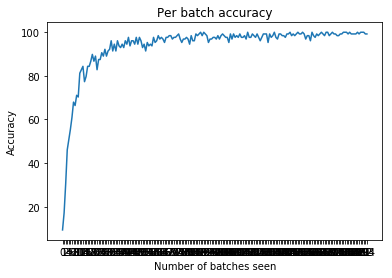

In [50]:
plot_accuracy(per_batch_acc[::50], 'Per batch accuracy')

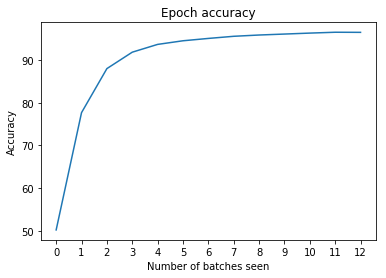

In [52]:
plot_accuracy(epoch_acc, 'Epoch accuracy')